In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')

# Fixed density boundary conditions

Hunting for the pressure drop during model start up did not yield any obvious hints (See [here](https://pad.gwdg.de/1TL7-VEpRiuyUEWQpzm8_w?both) and [here](https://gitlab.gwdg.de/hernan.campos/warm_eurec4a/-/blob/main/03_adiabatic_warming/adjusting_pressure.ipynb)). One suspicion is that we are loosing mass at the boundaries somehow. We were not able to confirm this. Nevertheless if we keep the density ($\rho$) fixed, no mass flux should be possible. We alreday mingle with half the variables in this equation:

$$ p = \rho \cdot R_{\text{specific}} \cdot T $$

$R_{\text{specific}}$ can be calculated as the weighted average of the gas constants of dry air and water vapor:

$$R_{\text{specific}} = R_d + ( R_v - R_d ) * q_v$$

We increase $T$, and $q_v$. To keep $\rho$ fixed $P$ has to be decreased. To be consistent we should calculate density with the same formula:

<!-- $$  \rho = \frac{P}{ T R_{\text{specific}}  } $$ -->
$$  \rho = p (R_{\text{specific}} \cdot T)^{-1} $$

This is the set of formulas Bjorn scribbled on the board. 

## Using the ideal gas equation

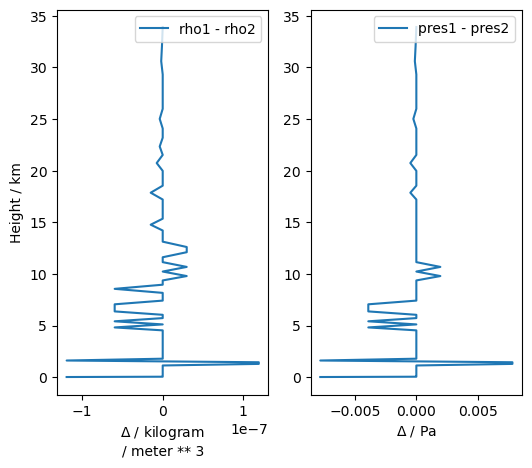

In [2]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import xarray as xr
import calculations as cc
import metpy.constants
from metpy.units import units

import matplotlib.pyplot as plt

def specific_gas_constant(specific_humidity):
    '''
    $R_{\text{specific}}$ can be calculated as the weighted average of the gas constants of dry air and water vapor:
    $$R_{\text{specific}} = R_d + ( R_v - R_d ) * q_v$$
    '''
    try: unit = specific_humidity.units # make sure specific_humidity has a unit.
    except: specific_humidity = specific_humidity * units('gram/kilogram')
    Rd = metpy.constants.dry_air_gas_constant 
    Rv = metpy.constants.water_gas_constant
    Rspecific = Rd.to_base_units() + (Rv.to_base_units() - Rd.to_base_units()) * specific_humidity.to_base_units()
    return Rspecific.to(Rd.units)

def pressure_from_ideal_gas(density, specific_humidity, temperature):
    ''' $$ P = \rho \cdot R_{\text{specific}} \cdot T $$ '''
    try: unit = density.units # make sure specific_humidity has a unit.
    except: density = density * units('kg / m**3')
    try: unit = temperature.units # make sure specific_humidity has a unit.
    except: temperature = temperature * units('kelvin')
    R = specific_gas_constant(specific_humidity)
    pressure = density.to_base_units() * R.to_base_units() * temperature.to_base_units()
    return pressure.to(units('Pa'))

def density_from_ideal_gas(pressure, specific_humidity, temperature):
    ''' $$  \rho = P (R_{\text{specific}} \cdot T)^{-1} $$ '''
    try: unit = pressure.units # make sure specific_humidity has a unit.
    except: pressure = pressure * units('Pa')
    try: unit = temperature.units # make sure specific_humidity has a unit.
    except: temperature = temperature * units('kelvin')
    R = specific_gas_constant(specific_humidity)
    density =  pressure.to_base_units() / (R.to_base_units() * temperature.to_base_units())
    return density.to(units('kg / m**3'))

def add_pressure_from_ideal_gas(dataset, varnames=False, target_name=False):
    varnames = cc.add_varnames_to_default(varnames)
    if not target_name: target_name = varnames['pressure']
    try: density = dataset[varnames['density']].values * units(str(dataset[varnames['density']].attrs['units']))
    except: raise ValueError(f'density not given under given name "{varnames["density"]}"')
    
    specific_humidity = dataset[varnames['specific humidity']].values * units('g / kg')
    temperature = dataset[varnames['temperature']].values * units('kelvin') 
    dimnames = dataset[varnames['pressure']].dims
    dataset[target_name] = (dimnames, pressure_from_ideal_gas(density, specific_humidity, temperature).magnitude)
    dataset[target_name] = dataset[target_name].assign_attrs({'long_name':'pressure', 'units':'Pa'})
    return dataset

def add_density_from_ideal_gas(dataset, varnames=None, target_name=False):
    varnames = cc.add_varnames_to_default(varnames)
    if not target_name: target_name = varnames['density']

    specific_humidity = dataset[varnames['specific humidity']].values * units('g / kg')
    temperature = dataset[varnames['temperature']].values * units('kelvin') 
    pressure = dataset[varnames['pressure']].values * units('Pa') 
    dimnames = dataset[varnames['pressure']].dims
    density = density_from_ideal_gas(pressure, specific_humidity, temperature)
    density = density.to(units('kg / m^3')) # comes as 'kg * Pa / J' which is the same with J = Pa m^3
    dataset[target_name] = (dimnames, density.magnitude)
    dataset[target_name] = dataset[target_name].assign_attrs({'long_name':'density', 'units':str(density.units)})
    return dataset

def example_profile():
    cc.add_varnames_to_default({'temperature':'temp', 'pressure':'pres'})
    BASE_PATH = '/work/mh1126/m300872/unchanged/'
    return xr.open_dataset(BASE_PATH+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc').mean(dim='time')

def linebreaks(string, n):
    with_breaks = ""
    for i, letter in enumerate(string):
        if i % 20 == 0:
            with_breaks += '\n'
        with_breaks += letter
    return with_breaks[1:]     # this is just because at the beginning too a `\n` character gets added

def fig_density_comparison():
    # varnames = cc.add_varnames_to_default({'temperature':'temp', 'pressure':'pres'})
    data = example_profile().isel(ncells=0)
    varnames = cc.add_varnames_to_default()
    data = add_density_from_ideal_gas(data, target_name='rho')  # for pressure calculation
    data = add_density_from_ideal_gas(data, target_name='rho1') # for plotting
    data = add_pressure_from_ideal_gas(data, target_name='pres')
    data = add_pressure_from_ideal_gas(data, target_name='pres1')
    data = add_density_from_ideal_gas(data, target_name='rho')  # overwrite for pressure calculation
    data = add_density_from_ideal_gas(data, target_name='rho2') 
    data = add_pressure_from_ideal_gas(data, target_name='pres2')

    fig, axs = plt.subplots(1,2, figsize=(6,5))
    y = cc.get_z_full(data['z_ifc']) / 1000
    
    labelslist = [('rho1', 'rho2'), ('pres1', 'pres2')]
    for ax, labels in zip(axs, labelslist):
        x = (data[labels[0]] - data[labels[1]]).values
        ax.plot(x,y, label=f'{labels[0]} - {labels[1]}')
        ax.set_xlabel(linebreaks(f'$\Delta$ / {data[labels[0]].units}',10))
        ax.legend()
    axs[0].set_ylabel('Height / km')
    return fig, axs

fig, ax = fig_density_comparison()
fig.show()

These very small differences very much look like numerical noise.

## Using Metpy's approach

[Metpy](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.density.html) does this to calculate density: 

$$\rho = \frac{\epsilon p\,(1+w)}{R_dT\,(w+\epsilon)}$$ 

or rearranged for p:

$$ p = \frac{\rho R_d T (w + \epsilon)}{\epsilon (1 + w)}$$ 

with the molecular [weight ratio](https://booksite.elsevier.com/9780127329512/Table%20of%20Constants%20and%20Conversion.pdf)

$$\epsilon \approx 0.622$$

and the [mixing ratio](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.mixing_ratio_from_specific_humidity.html):

$$w = \frac{q_v}{1 - q_v}$$

<!-- $$\rho = \frac{\epsilon p\,(1 + \frac{q_v}{1 - q_v})}{R_dT\,(\frac{q_v}{1 - q_v}+\epsilon)}$$  -->
<!-- with $\epsilon \approx 0.622$ and $w = $ -->





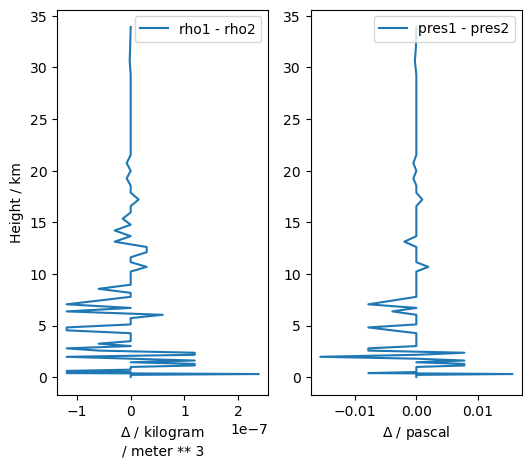

In [3]:
def mixing_ratio(qv): 
    return qv / (1 - qv)

def density_metpy_equation(pressure, specific_humidity, temperature):
    # ''' $$  \rho = P (R_{\text{specific}} \cdot T)^{-1} $$ '''
    Rd = metpy.constants.dry_air_gas_constant
    epsilon = metpy.constants.molecular_weight_ratio
    try: unit = specific_humidity.units # make sure specific_humidity has a unit.
    except: specific_humidity = specific_humidity * units('gram/kilogram')
    
    upper = epsilon.to_base_units() * pressure.to_base_units() * (1 + mixing_ratio(specific_humidity.to_base_units()))
    lower = Rd.to_base_units() * temperature.to_base_units() * (mixing_ratio(specific_humidity.to_base_units()) + epsilon.to_base_units())
    return (upper / lower).to(units('kg / m**3'))

def pressure_metpy_equation(density, specific_humidity, temperature):
    # ''' $$  \rho = P (R_{\text{specific}} \cdot T)^{-1} $$ '''
    Rd = metpy.constants.dry_air_gas_constant
    epsilon = metpy.constants.molecular_weight_ratio
    try: unit = specific_humidity.units # make sure specific_humidity has a unit.
    except: specific_humidity = specific_humidity * units('gram/kilogram')
    
    upper = density.to_base_units() * Rd.to_base_units() * temperature.to_base_units() * (mixing_ratio(specific_humidity.to_base_units()) + epsilon.to_base_units())
    lower = epsilon.to_base_units() * (1 + mixing_ratio(specific_humidity.to_base_units()))
    return (upper / lower).to(units('Pa'))

def add_pressure_metpy_equation(dataset, varnames=False, target_name=False):
    varnames = cc.add_varnames_to_default(varnames)
    if not target_name: target_name = varnames['pressure']
    
    try: density = dataset[varnames['density']].values * units(str(dataset[varnames['density']].attrs['units']))
    except: raise ValueError(f'density not given under given name "{varnames["density"]}"')
    specific_humidity = dataset[varnames['specific humidity']].values * units('g / kg')
    temperature = dataset[varnames['temperature']].values * units('kelvin') 
    dimnames = dataset[varnames['pressure']].dims
    pressure = pressure_metpy_equation(density, specific_humidity, temperature)
    pressure = pressure.to(units('Pa'))
    dataset[target_name] = (dimnames, pressure.magnitude)
    dataset[target_name] = dataset[target_name].assign_attrs({'long_name':'pressure', 'units':str(pressure.units)})
    return dataset

def add_density_metpy_equation(dataset, varnames=None, target_name=False):
    varnames = cc.add_varnames_to_default(varnames)
    if not target_name: target_name = varnames['density']

    specific_humidity = dataset[varnames['specific humidity']].values * units('g / kg')
    temperature = dataset[varnames['temperature']].values * units('kelvin') 
    pressure = dataset[varnames['pressure']].values * units('Pa') 
    
    dimnames = dataset[varnames['pressure']].dims
    density = density_metpy_equation(pressure, specific_humidity, temperature)
    # density comes as 'kg * Pa / J' which is the same as 'kg / m^3' with J = Pa m^3
    density = density.to(units('kg / m^3')) 
    dataset[target_name] = (dimnames, density.magnitude)
    dataset[target_name] = dataset[target_name].assign_attrs({'long_name':'density', 'units':str(density.units)})
    return dataset

def fig_density_comparison():
    varnames = cc.add_varnames_to_default()
    data = example_profile().isel(ncells=0)
    data = add_density_metpy_equation(data, target_name='rho')  # for pressure calculation
    data = add_density_metpy_equation(data, target_name='rho1') # for plotting
    data = add_pressure_metpy_equation(data, target_name='pres')
    data = add_pressure_metpy_equation(data, target_name='pres1')
    data = add_density_metpy_equation(data, target_name='rho')  # overwrite for pressure calculation
    data = add_density_metpy_equation(data, target_name='rho2') # for plotting
    data = add_pressure_metpy_equation(data, target_name='pres2')

    fig, axs = plt.subplots(1,2, figsize=(6,5))
    y = cc.get_z_full(data['z_ifc']) / 1000
    
    labelslist = [('rho1', 'rho2'), ('pres1', 'pres2')]
    for ax, labels in zip(axs, labelslist):
        x = (data[labels[0]] - data[labels[1]]).values
        ax.plot(x,y, label=f'{labels[0]} - {labels[1]}')
        ax.set_xlabel(linebreaks(f'$\Delta$ / {data[labels[0]].units}',10))
        ax.legend()
    axs[0].set_ylabel('Height / km')
    return fig, ax

fig, ax = fig_density_comparison()
fig.show()

## Comparison of the formulas

Now we got two different approaches. It is not obvious to me what their difference is, from the formula alone. They use different approaches to get the information on the specific properties of the gas that is a mixture of dry air and water vapor. The ratio of this mixture ultimately is given by `qv`. While Bjorns formula uses a weighted average of the two specific gas constants, in metpys formula the specific gas constant of water vapor is hidden in the molecular weight ratio $\epsilon$.

$$\epsilon = \frac{M_w}{M_d} $$

$$R_{{{\rm {specific}}}}={\frac {R}{M}}$$

So there is quite some redundancy in the available constants, as we can see here:

In [4]:
import metpy.constants
import scipy.constants
from metpy.units import units
import math

def print_constant_relationships():
    Rv  = metpy.constants.water_gas_constant
    Rd  = metpy.constants.dry_air_gas_constant
    R   = scipy.constants.gas_constant * units('joule / kelvin / mole')
    eps = metpy.constants.molecular_weight_ratio
    Md  = metpy.constants.dry_air_molecular_weight.to(units('g/mol'))
    Mw  = metpy.constants.water_molecular_weight

    print('confimation of relationship of several constants:\n')
    print('R       ', R)
    print('Rv*Mw   ', Rv*Mw)
    print('Rd*Md   ', (Rd*Md).to((Rv*Mw).units))
    print()
    print('Rd      ', Rd)
    print('R/Md    ', (R/Md).to(Rd.units))
    print()
    print('Rv      ', Rv.to(Rd.units))
    print('R/Mw    ', (R/Mw).to(Rd.units))
    print()
    print('Md      ', Md)
    print('R/Rd    ', (R/Rd).to(Md.units))
    print()
    print('Mw      ', Mw)
    print('R/Rw    ', (R/Rv).to(Mw.units))
    print()
    print('epsilon       ', eps)
    print('Mw/Md         ', (Mw/Md))
    print('(R/Rv)/(R/Rd) ', ((R/Rv)/(R/Rd)).to(units('dimensionless')) )
    
print_constant_relationships()

confimation of relationship of several constants:

R        8.314462618 joule / kelvin / mole
Rv*Mw    8.314462618 joule / kelvin / mole
Rd*Md    8.314462618000002 joule / kelvin / mole

Rd       287.04749097718457 joule / kelvin / kilogram
R/Md     287.04749097718457 joule / kelvin / kilogram

Rv       461.52311572606084 joule / kelvin / kilogram
R/Mw     461.52311572606084 joule / kelvin / kilogram

Md       28.96546 gram / mole
R/Rd     28.96546 gram / mole

Mw       18.015268 gram / mole
R/Rw     18.015268 gram / mole

epsilon        0.6219569100577033 dimensionless
Mw/Md          0.6219569100577031 dimensionless
(R/Rv)/(R/Rd)  0.6219569100577033 dimensionless


If we insert the the definitions of the redundant term we get the following two equations ($\rho_{BS}$: Bjorns equation, $\rho_{MP}$: metpy):

$$ \rho_{BS} = \frac{p}{ T (\frac{R}{M_d} +q_v ( \frac{R}{M_v} - \frac{R}{M_d} ) )  } ; \rho_{MP} = \frac{\frac{M_w}{M_d} p (1 + \frac{q_v}{1 - q_v})}{\frac{R}{M_d} T (\frac{q_v}{1 - q_v} + \frac{M_w}{M_d})}$$ 

inserting made them a mess. We will simplify the functions, starting with the metpy one ($\rho_{MP}$)

$$ \rho_{MP} = \frac{p}{T} \frac{\frac{M_w}{M_d} (1 + \frac{q_v}{1 - q_v})}{\frac{R}{M_d}(\frac{q_v}{1 - q_v} + \frac{M_w}{M_d})} $$ 

$$  = \frac{p}{T} \frac{\frac{M_w}{M_d} \frac{1}{1-q_v}}  {\frac{R}{M_d}  \frac{\frac{M_w}{M_d} (1 - q_v) + q_v}{1 - q_v}} $$ 

$$  = \frac{p}{T} \frac{\frac{M_w}{M_d}}{\frac{R}{M_d}} \frac{1}{ \frac{M_w}{M_d} (1 - q_v) + q_v} $$ 

$$  = \frac{p}{T} \frac{M_w}{R} \frac{1}{ \frac{M_w - q_v M_w + q_v M_d}{M_d} } $$ 

$$ = \frac{p}{T} \frac{M_w}{R} \frac{1}{ \frac{M_w - q_v M_w + q_v M_d}{M_d} } $$ 

$$ = \frac{p}{T} \frac{M_w}{R} \frac{M_d}{M_w - q_v M_w + q_v M_d} $$ 

$$  = \frac{p}{T} \frac{M_w M_d }{R (M_w - q_v M_w + q_v M_d)} $$ 

And the Bjorn approach:

$$ \rho_{BS} = \frac{p}{ T (\frac{R}{M_d} +q_v ( \frac{R}{M_w} - \frac{R}{M_d} ) )  } $$

$$ = \frac{p}{T} \frac{1}{ \frac{R}{M_d} + \frac{R q_v}{M_w} - \frac{R q_v}{M_d}  } $$

$$ = \frac{p}{T} \frac{1}{ \frac{R M_w}{M_w M_d } + \frac{R q_v M_d}{M_w M_d} - \frac{R q_v M_w}{M_w M_d}  } $$

$$ = \frac{p}{T} \frac{M_w M_d}{ R M_w + R q_v M_d - R q_v M_w  } $$

$$ = \frac{p}{T} \frac{M_w M_d}{ R (M_w - q_v M_w + q_v M_d )  } $$

Suprise! They are the same.

Let's compare them on our example profile:

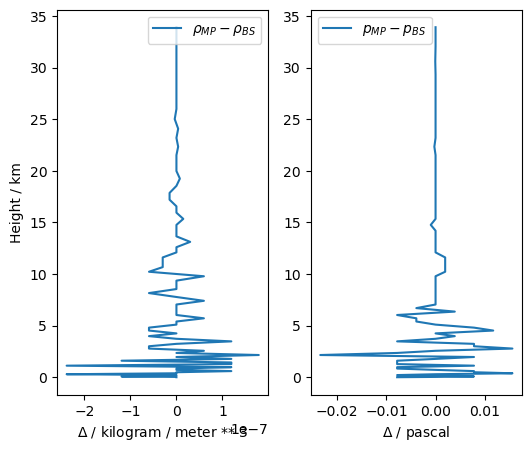

In [5]:
def fig_density_comparison():
    varnames = cc.add_varnames_to_default()
    
    data = example_profile().isel(ncells=0)
    data = add_density_metpy_equation(data, target_name='rho_mp') # for comparing the two approaches
    data = add_density_from_ideal_gas(data, target_name='rho_bs')
    data = add_density_metpy_equation(data, target_name='rho')    # one of them has to be the basis for the reversion
    data = add_pressure_metpy_equation(data, target_name='pres')
    data = add_pressure_metpy_equation(data, target_name='pres_mp')
    data = add_pressure_from_ideal_gas(data, target_name='pres_bs')
    
    fig, axs = plt.subplots(1,2, figsize=(6,5))
    y = cc.get_z_full(data['z_ifc']) / 1000
    # for ax, var in zip(axs, ['rho','pres']):
    
    ax = axs[0]
    x = (data['rho_mp'] - data['rho_bs']).values
    ax.plot(x,y, label=r'$\rho_{MP} - \rho_{BS}$')
    ax.set_xlabel(f'$\Delta$ / {data["rho_mp"].units}')
    ax.legend()
    
    ax = axs[1]
    x = (data['pres_mp'] - data['pres_bs']).values
    ax.plot(x,y, label=r'$p_{MP} - p_{BS}$')
    ax.set_xlabel(f'$\Delta$ / {data["pres_mp"].units}')
    ax.legend()
    
    axs[0].set_ylabel('Height / km')
    return fig, ax


fig, ax = fig_density_comparison()
fig.show()

The difference shows the same picture as the individual functions: Almost zero, with some numerical noise. The noise seems to scale negatively with height, which makes sense as the involved variables (mainly pressure) do so, too.

## Create a new fixed density delta

surface pressure:
  ctrl.initcon    1015.2351
  warm.initcon    1015.2351
  ctrl.latbc      1015.7184
  warm.latbc      1015.7184
surface temperature:
  ctrl.initcon    298.82706
  warm.initcon    302.82703
  ctrl.latbc      299.1157
  warm.latbc      303.1157
surface virtual potential temperature:
  ctrl.initcon    300.2351
  warm.initcon    304.9916332745015
  ctrl.latbc      300.61917
  warm.latbc      305.4116994199305
surface density:
  ctrl.initcon    1.1729784
  warm.initcon    1.1546581579547406
  ctrl.latbc      1.1718382
  warm.latbc      1.1534496721140401


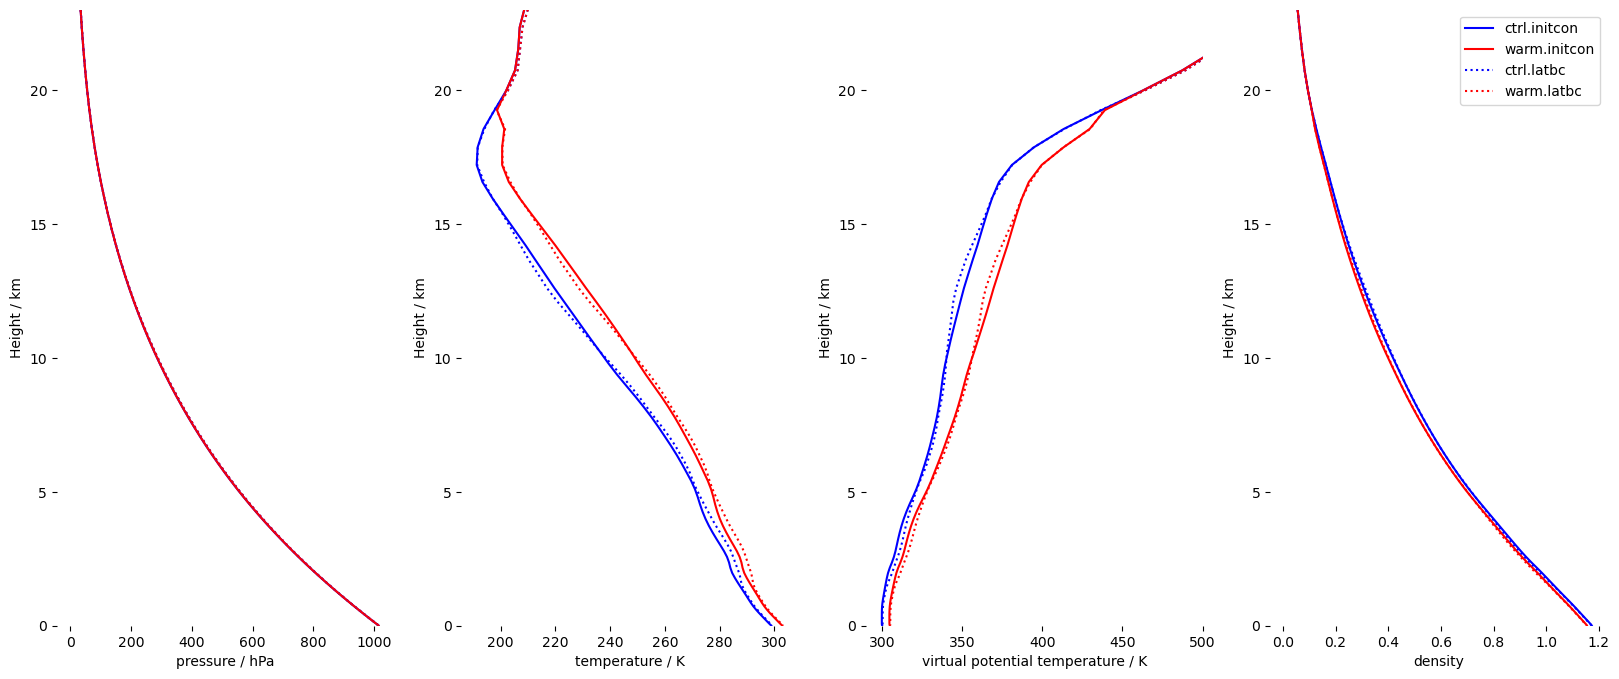

In [6]:
import file_handling as fh
import matplotlib.pyplot as plt
import plot_utils as pu

def load_mintake():
    data = fh.MinIntake()
    data.ctrl = fh.MinIntake()
    data.warm = fh.MinIntake()
    data.ctrl.latbc = xr.open_dataset('data/profile_ctrl_latbc.nc')
    data.warm.latbc = xr.open_dataset('data/profile_warm_latbc.nc')
    data.ctrl.initcon = xr.open_dataset('data/profile_ctrl_initcon.nc')
    data.warm.initcon = xr.open_dataset('data/profile_warm_initcon.nc')
    return data

def fig_profiles(data, verbose=False):
    figsize=(20,8)
    fig, axs = plt.subplots(1,4, figsize=figsize)

    y = data.ctrl.initcon['z'].values / 1000
    kwargs=[{'color' : 'blue'},
            {'color' : 'red'},
            {'color' : 'blue', 'ls' : ':'},
            {'color' : 'red', 'ls' : ':'},]
    labels = ['ctrl.initcon', 'warm.initcon', 'ctrl.latbc', 'warm.latbc']

    ax = axs[0]
    arrays = [data.ctrl.initcon['p'].values / 100, 
              data.warm.initcon['p'].values / 100,
              data.ctrl.latbc['pres'].values / 100,
              data.warm.latbc['pres'].values / 100]
    if verbose: 
        print('surface pressure:')
        for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
    
    # labels = ['initcon', 'latbc']
    # arrays = [np.abs(data.ctrl.initcon['p'].values  - data.warm.initcon['p'].values)  / 100, 
    #           np.abs(data.ctrl.latbc['pres'].values - data.warm.latbc['pres'].values) / 100]
    for x, kw in zip(arrays, kwargs):
        ax.plot(x,y,**kw)
    ax.set_xlabel('pressure / hPa')

    ax = axs[1]
    arrays = [data.ctrl.initcon['t'].values, 
              data.warm.initcon['t'].values,
              data.ctrl.latbc['temp'].values,
              data.warm.latbc['temp'].values]
    if verbose: 
        print('surface temperature:')
        for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
    for x, kw in zip(arrays, kwargs):
        ax.plot(x,y,**kw)
    ax.set_xlabel('temperature / K')

    ax = axs[2]
    arrays = [data.ctrl.initcon['theta_v'].values, 
              data.warm.initcon['theta_v'].values,
              data.ctrl.latbc['theta_v'].values,
              data.warm.latbc['theta_v'].values]
    if verbose: 
        print('surface virtual potential temperature:')
        for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
    for x, kw in zip(arrays, kwargs):
        ax.plot(x,y,**kw)
    ax.set_xlabel('virtual potential temperature / K')
    ax.set_xlim([290,500])

    ax = axs[3]
    arrays = [data.ctrl.initcon['rho'].values, 
              data.warm.initcon['rho'].values,
              data.ctrl.latbc['rho'].values,
              data.warm.latbc['rho'].values]
    if verbose: 
        print('surface density:')
        for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
    for x, kw, label in zip(arrays, kwargs, labels):
        ax.plot(x,y,**kw, label=label)
    ax.set_xlabel('virtual potential temperature / K')
    ax.set_xlabel('density')
    ax.legend()

    for ax in axs: 
        pu.remove_spines(ax)
        ax.set_ylabel('Height / km')
        ax.set_ylim([0,23])
    return fig, axs
    
fig, axs = fig_profiles(load_mintake(), verbose=True)
fig.show()

rh first, then pressure
surface pressure:
  ctrl.initcon    1015.2351
  warm.initcon    1028.827210509096
  ctrl.latbc      1015.7184
  warm.latbc      1029.3038867022156
surface temperature:
  ctrl.initcon    298.82706
  warm.initcon    302.8270568847656
  ctrl.latbc      299.1157
  warm.latbc      303.1156921386719
surface virtual potential temperature:
  ctrl.initcon    300.2351
  warm.initcon    303.8345468548178
  ctrl.latbc      300.61917
  warm.latbc      304.254639259345
surface density:
  ctrl.initcon    1.1729784
  warm.initcon    1.1701057728539643
  ctrl.latbc      1.1718382
  warm.latbc      1.1688768548172646


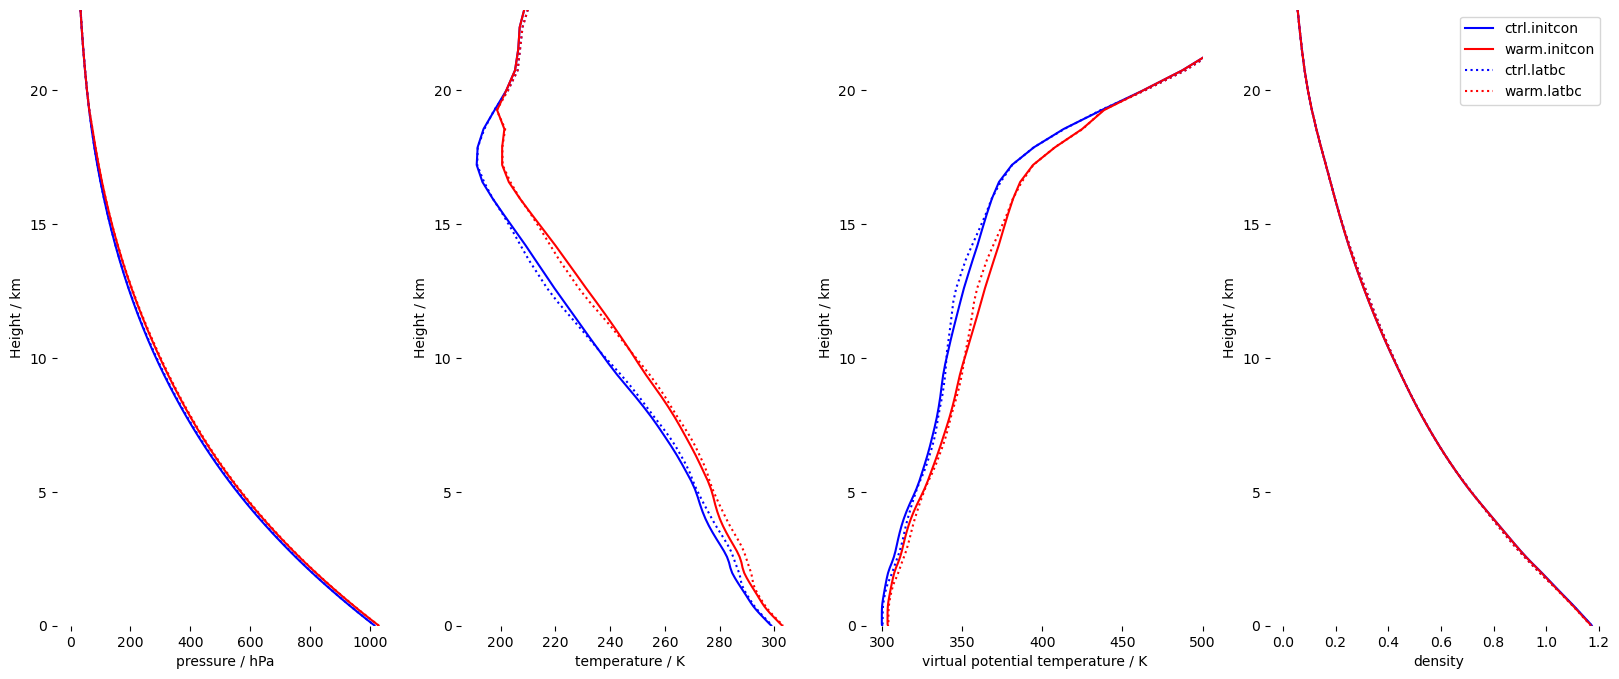

In [7]:
def delta_adiabatic_profile(t_high, t_low, heights, p_surf=100000):
    p = cc.hydrostatic_profile(heights, p_surf)
    delta = cc.joined_profile(p, T_s=t_high) - cc.joined_profile(p, T_s=t_low)
    return delta

def altered_mintake(relative_humidity_first=True):
    cat = fh.MinIntake()
    cat.ctrl = fh.MinIntake()
    cat.warm = fh.MinIntake()
    cat.ctrl.latbc = xr.open_dataset('data/profile_ctrl_latbc.nc')
    cat.ctrl.initcon = xr.open_dataset('data/profile_ctrl_initcon.nc')
    
    varnames = cc.add_varnames_to_default({'pressure':'pres', 'temperature':'temp'})
    data = xr.open_dataset('data/profile_ctrl_latbc.nc')
    
    heights = data[varnames['half level height']]
    heights = cc.interpolate_full_level(heights)
    heights = np.flip(heights)
    warming_profile = delta_adiabatic_profile(304, 300, heights, p_surf=100000)
    warming_profile = np.flip(warming_profile)
    
    data = add_density_metpy_equation(data, varnames=varnames)
    data = cc.add_relative_humidity(data, varnames=varnames)
    data = cc.add_to_temperature(data, warming_profile, varnames=varnames)
    if relative_humidity_first:
        print('rh first, then pressure')
        data = cc.restore_specific_humidity(data, varnames=varnames, drop_RH=True)
        data = add_pressure_metpy_equation( data, varnames=varnames)
    else:
        print('p first, then rh')
        data = add_pressure_metpy_equation( data, varnames=varnames)
        data = cc.restore_specific_humidity(data, varnames=varnames, drop_RH=True)

    data = cc.add_prognostic_variables(data, varnames=varnames)
    cat.warm.latbc = data
    
    varnames = cc.add_varnames_to_default({'pressure':'p', 'temperature':'t'})
    data = xr.open_dataset('data/profile_ctrl_initcon.nc')
    
    data = add_density_metpy_equation(data, varnames=varnames)
    data = cc.add_relative_humidity(data, varnames=varnames)
    data = cc.add_to_temperature(data, warming_profile, varnames=varnames)
    if relative_humidity_first:
        data = cc.restore_specific_humidity(data, varnames=varnames, drop_RH=True)
        data = add_pressure_metpy_equation( data, varnames=varnames)
    else:
        data = add_pressure_metpy_equation( data, varnames=varnames)
        data = cc.restore_specific_humidity(data, varnames=varnames, drop_RH=True)
    data = cc.add_prognostic_variables(data, varnames=varnames)
    cat.warm.initcon = data

    return cat

fig, axs = fig_profiles(altered_mintake(), verbose=True)
fig.show()

rh first, then pressure


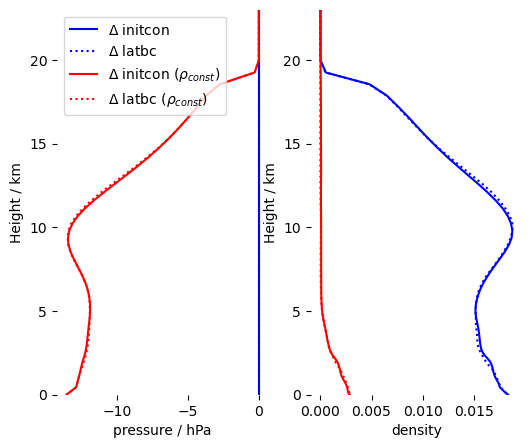

In [8]:
def fig_diff_profiles_p_rho(relative_humidity_first=True):
    figsize=(6,5)
    fig, axs = plt.subplots(1,2, figsize=figsize)
    
    for data, kwargs, labels in zip([load_mintake(), altered_mintake(relative_humidity_first=relative_humidity_first)],
                            [[{'color' : 'blue'}, {'color' : 'blue', 'ls' : ':'}],
                             [{'color' : 'red'}, {'color' : 'red', 'ls' : ':'}]],
                            [['$\Delta$ initcon', '$\Delta$ latbc'],[r'$\Delta$ initcon ($\rho_{const}$)', r'$\Delta$ latbc ($\rho_{const}$)']]):

        y = data.ctrl.initcon['z'].values / 1000
        ax = axs[0]
        arrays = [data.ctrl.initcon['p'].values / 100  - data.warm.initcon['p'].values / 100,
                  data.ctrl.latbc['pres'].values / 100 - data.warm.latbc['pres'].values / 100]
        for x, kw, label in zip(arrays, kwargs, labels):
            ax.plot(x,y,**kw, label=label)
        ax.set_xlabel('pressure / hPa')

        ax = axs[1]
        arrays = [data.ctrl.initcon['rho'].values - data.warm.initcon['rho'].values,
                  data.ctrl.latbc['rho'].values   - data.warm.latbc['rho'].values]
        for x, kw, label in zip(arrays, kwargs, labels):
            ax.plot(x,y,**kw, label=label)
        ax.set_xlabel('density')
        
    axs[0].legend()
    for ax in axs: 
        pu.remove_spines(ax)
        ax.set_ylabel('Height / km')
        ax.set_ylim([0,23])
    return fig, axs

fig, axs = fig_diff_profiles_p_rho()
fig.show()

The calculation of density depends on `qv`, which we change when restoring relative humidity. Likewise relative humidity depends on pressure. Thus the order in which we change them might influence the outcome, but this does not seem to play a role.

p first, then rh


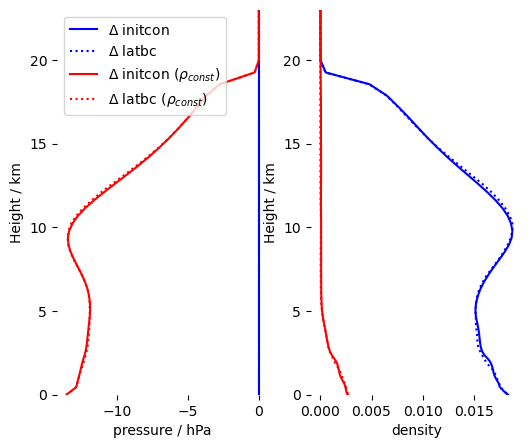

In [9]:
fig, axs = fig_diff_profiles_p_rho(relative_humidity_first=False)
fig.show()

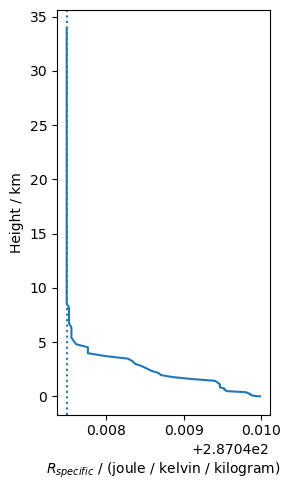

In [10]:
import metpy.constants 

def fig_R_spec():
    varnames = cc.add_varnames_to_default()
    data = example_profile().isel(ncells=0)
    fig, ax = plt.subplots(figsize=(3,5))
    y = cc.get_z_full(data['z_ifc']) / 1000
    x = specific_gas_constant(data['qv'].values)
    ax.plot(x,y, )
    ax.axvline(metpy.constants.dry_air_gas_constant, ls=':', label='Rd')
    ax.set_ylabel('Height / km')
    ax.set_xlabel(r'$R_{specific}$ / ('+str(x[0].units)+')', labelpad=16)
    fig.tight_layout()
    return fig, ax

fig, ax = fig_R_spec()
fig.show()

## Produce boundary conditions

first we migrate the functions to `calculations.py`

surface pressure:
  ctrl.initcon    1015.2351
  warm.initcon    1028.8273188405822
  ctrl.latbc      1015.7184
  warm.latbc      1029.304004172083
surface temperature:
  ctrl.initcon    298.82706
  warm.initcon    302.8270568847656
  ctrl.latbc      299.1157
  warm.latbc      303.1156921386719
surface virtual potential temperature:
  ctrl.initcon    300.2351
  warm.initcon    303.8345377140782
  ctrl.latbc      300.61917
  warm.latbc      304.2546293384238
surface density:
  ctrl.initcon    1.1729784
  warm.initcon    1.1701058960615311
  ctrl.latbc      1.1718382
  warm.latbc      1.168876988215973


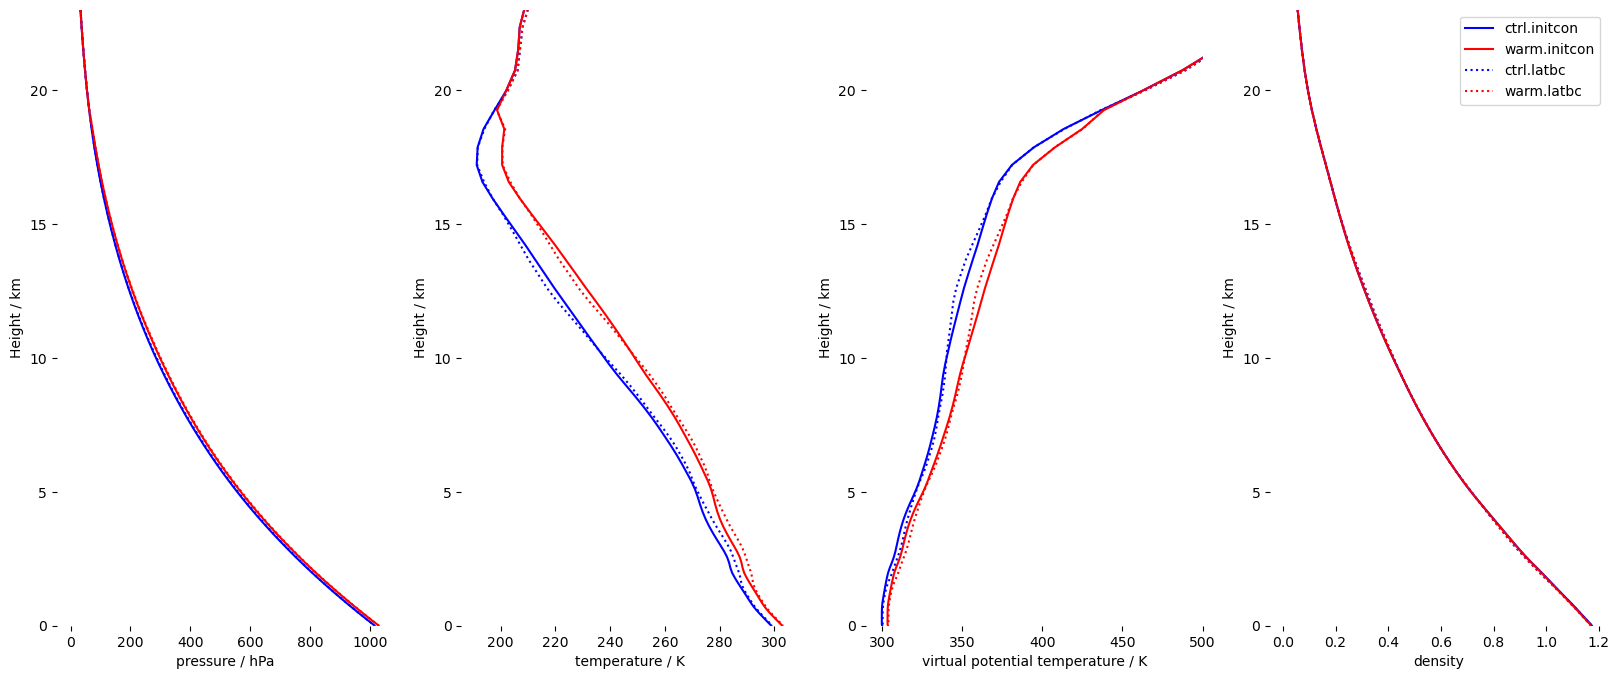

In [11]:
def apply_warming_rho_fixed(dataset, varnames=None):
    heights = dataset[varnames['half level height']]
    heights = cc.interpolate_full_level(heights)
    heights = np.flip(heights)
    warming_profile = cc.delta_adiabatic_profile(304, 300, heights, p_surf=100000)
    warming_profile = np.flip(warming_profile)
    
    dataset = cc.save_density(             dataset, varnames=varnames)
    dataset = cc.add_relative_humidity(    dataset, varnames=varnames)
    dataset = cc.add_to_temperature(       dataset, warming_profile, varnames=varnames)
    dataset = cc.restore_specific_humidity(dataset, varnames=varnames, drop_RH=True)
    dataset = cc.restore_pressure(         dataset, varnames=varnames)
    return dataset

def altered_mintake(relative_humidity_first=True):
    cat = fh.MinIntake()
    cat.ctrl = fh.MinIntake()
    cat.warm = fh.MinIntake()
    cat.ctrl.latbc = xr.open_dataset('data/profile_ctrl_latbc.nc')
    cat.ctrl.initcon = xr.open_dataset('data/profile_ctrl_initcon.nc')
    
    varnames = cc.add_varnames_to_default({'pressure':'pres', 'temperature':'temp'})
    data = xr.open_dataset('data/profile_ctrl_latbc.nc')
    data = apply_warming_rho_fixed(data, varnames=varnames)
    data = cc.add_prognostic_variables(data, varnames=varnames)
    cat.warm.latbc = data
    
    varnames = cc.add_varnames_to_default({'pressure':'p', 'temperature':'t'})
    data = xr.open_dataset('data/profile_ctrl_initcon.nc')
    data = apply_warming_rho_fixed(data, varnames=varnames)
    data = cc.add_prognostic_variables(data, varnames=varnames)
    cat.warm.initcon = data

    return cat

fig, axs = fig_profiles(altered_mintake(), verbose=True)
fig.show()

surface pressure:
  ctrl.initcon    1015.2351
  warm.initcon    1028.8273188405822
  ctrl.latbc      1015.7184
  warm.latbc      1029.304004172083
surface temperature:
  ctrl.initcon    298.82706
  warm.initcon    302.8270568847656
  ctrl.latbc      299.1157
  warm.latbc      303.1156921386719
surface virtual potential temperature:
  ctrl.initcon    300.2351
  warm.initcon    303.8345377140782
  ctrl.latbc      300.61917
  warm.latbc      304.2546293384238
surface density:
  ctrl.initcon    1.1729784
  warm.initcon    1.1701058960615311
  ctrl.latbc      1.1718382
  warm.latbc      1.168876988215973


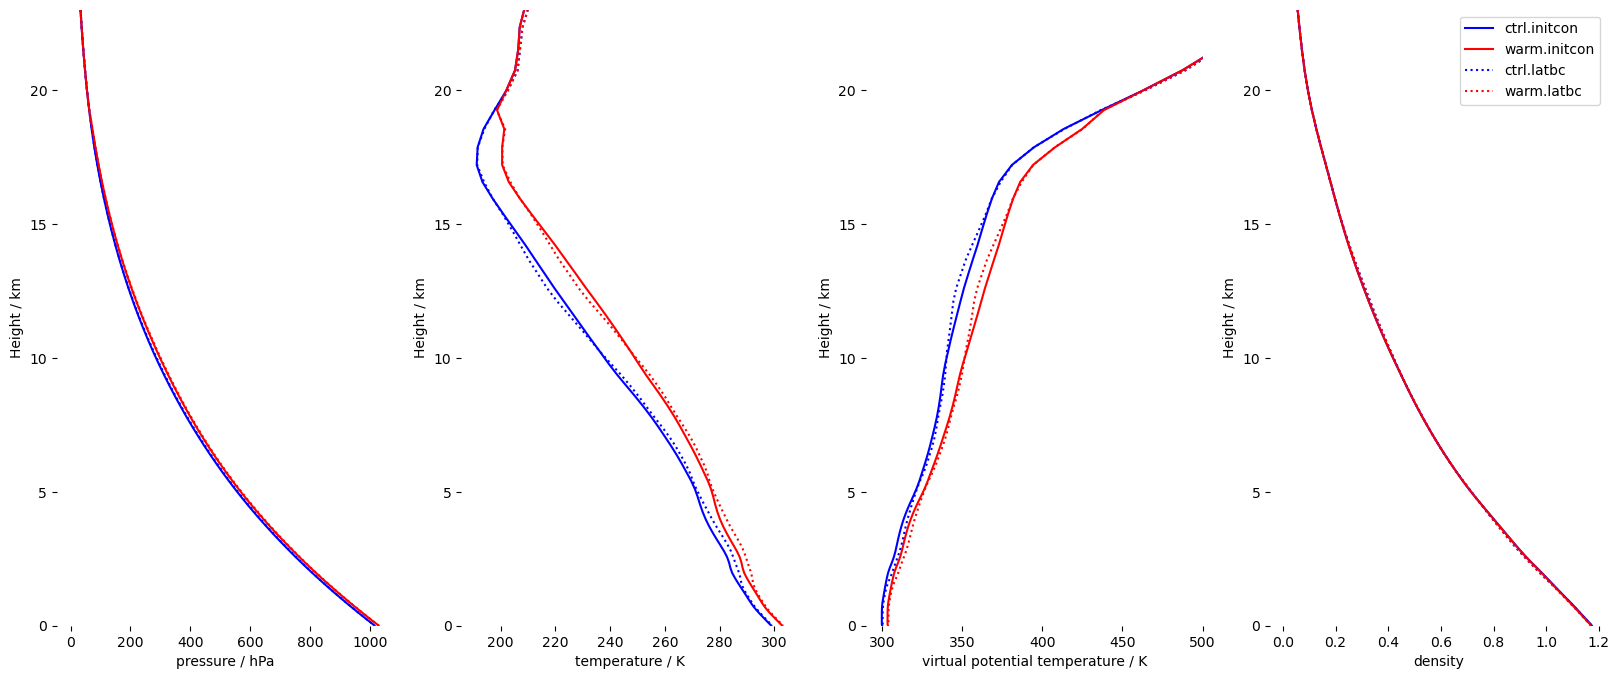

In [12]:
def altered_mintake(relative_humidity_first=True):
    cat = fh.MinIntake()
    cat.ctrl = fh.MinIntake()
    cat.warm = fh.MinIntake()
    cat.ctrl.latbc = xr.open_dataset('data/profile_ctrl_latbc.nc')
    cat.ctrl.initcon = xr.open_dataset('data/profile_ctrl_initcon.nc')
    
    varnames = cc.add_varnames_to_default({'pressure':'pres', 'temperature':'temp'})
    data = xr.open_dataset('data/profile_ctrl_latbc.nc')
    data = cc.apply_warming_rho_fixed(data, varnames=varnames)
    data = cc.add_prognostic_variables(data, varnames=varnames)
    cat.warm.latbc = data
    
    varnames = cc.add_varnames_to_default({'pressure':'p', 'temperature':'t'})
    data = xr.open_dataset('data/profile_ctrl_initcon.nc')
    data = cc.apply_warming_rho_fixed(data, varnames=varnames)
    data = cc.add_prognostic_variables(data, varnames=varnames)
    cat.warm.initcon = data

    return cat

fig, axs = fig_profiles(altered_mintake(), verbose=True)
fig.show()

Now we test manipulating a single file.

In [21]:

import os
import subprocess as sub

in_directory='/work/mh1126/m300872/unchanged/'
out_directory='/work/mh1126/m300872/moist_adiabatic/'
out_directory='/scratch/m/m300872/temp/'
temperatures=(304,300)

IN_DIRECTORY  = in_directory
OUT_DIRECTORY = out_directory
latbc_files = [f for f in fh.get_filelist(IN_DIRECTORY, 'latbc/') if not 'grid' in f]

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = cc.apply_warming_rho_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)
    
ifile = os.path.join(in_directory,  latbc_files[0])
ofile = os.path.join(out_directory, os.path.basename(latbc_files[0]))
varnames = cc.add_varnames_to_default({'temperature':'temp', 'pressure':'pres'})
warm_atmospheric_profile(ifile, ofile, varnames)

sub.call(['cdo', 'diffn', ifile, ofile])

Warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
Warning (cdf_set_var): Inconsistent variable definition for clat_bnds!


               Date     Time   Level Gridsize    Miss    Diff : S Z  Max_Absdiff Max_Reldiff : Parameter name
   153 : 2020-01-08 01:00:00       1   174068       0  174068 : F F   1.7034e-06     0.35205 : qv         
   154 : 2020-01-08 01:00:00       2   174068       0  174068 : F F   1.6332e-06     0.35914 : qv         
   155 : 2020-01-08 01:00:00       3   174068       0  174068 : F F   1.6854e-06     0.37333 : qv         
   156 : 2020-01-08 01:00:00       4   174068       0  174068 : F F   1.6741e-06     0.37606 : qv         
   157 : 2020-01-08 01:00:00       5   174068       0  174068 : F F   1.7144e-06     0.37941 : qv         
   158 : 2020-01-08 01:00:00       6   174068       0  174068 : F F   1.7889e-06     0.38314 : qv         
   159 : 2020-01-08 01:00:00       7   174068       0  174068 : F F   1.8764e-06     0.38643 : qv         
   160 : 2020-01-08 01:00:00       8   174068       0  174068 : F F   2.0714e-06     0.39879 : qv         
   161 : 2020-01-08 01:00:00      

1

## Production
Finally create all the files.

In [30]:
import xarray as xr
import os 
import calculations as cc 
import importlib
importlib.reload(fh)

temperatures=(304,300)
IN_DIRECTORY  = '/work/mh1126/m300872/unchanged/'
OUT_DIRECTORY = '/work/mh1126/m300872/moist_adiabatic/'

print('IN_DIRECTORY', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY', OUT_DIRECTORY, flush=True)

division = (100, 0)
# latbc_files = [f for f in list_files(IN_DIRECTORY+'latbc/', 'latbc/') if not 'grid' in f]
# latbc_files = [f for f in fh.list_files(IN_DIRECTORY, keywords=['latbc', '.nc', 'latbc_EUREC4A_PR1250m'] ) if not 'grid' in f]
latbc_files = fh.list_files(IN_DIRECTORY, keywords=['latbc', '.nc', 'latbc_EUREC4A_PR1250m'] )
print(len(latbc_files))
fh.create_directory_structure(latbc_files, OUT_DIRECTORY)
if division: latbc_files = fh.sublist(latbc_files, division[0], division[1])

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    # d = apply_warming_rho_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)

print('division: ', division, flush=True)

latbc_varnames = dict()
latbc_varnames["pressure"] = "pres"
latbc_varnames["temperature"] = "temp"
varnames = cc.get_varnames(latbc_varnames)

def try_remove(path):
    try:os.remove(path)
    except: pass

args_list = list()
for f in latbc_files:
    ifile = os.path.abspath(os.path.join(IN_DIRECTORY,f))
    ofile = os.path.abspath(os.path.join(OUT_DIRECTORY,f))
    args_list.append((ifile, ofile, varnames))

for args in args_list:
    print('in: ', args[0], os.path.exists(args[0]), flush=True)
    #if os.path.exists(args[1]): 
    #    print('exists', flush=True)
    #else: print('does not exist', flush=True)
    print('out:', args[1], os.path.exists(args[1]), flush=True)
    
    #print(args[2], flush=True)
    #print(flush=True)
    #print('deleting', flush=True)
    try_remove(args[1])
    #if os.path.exists(args[1]): 
    #    print('exists', flush=True)
    #else: print('does not exist', flush=True)
    # warm_atmospheric_profile(*args)
    print('done', flush=True)
    print('', flush=True)

IN_DIRECTORY /work/mh1126/m300872/unchanged/
OUT_DIRECTORY /work/mh1126/m300872/moist_adiabatic/
1023
division:  (100, 0)
in:  /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc True
out: /work/mh1126/m300872/moist_adiabatic/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc True
done

in:  /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010802.nc True
out: /work/mh1126/m300872/moist_adiabatic/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010802.nc True
done

in:  /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010803.nc True
out: /work/mh1126/m300872/moist_adiabatic/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010803.nc True
done

in:  /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010804.nc True
out: /work/mh1126/m300872/moist_adiabatic/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010804.nc True
done

in:  /work/mh1126/m300872/unchanged/latbc/2020

In [33]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import subprocess as sup

def latbc_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic/',
                      temperatures=(304,300)):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'

print('IN_DIRECTORY', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY', OUT_DIRECTORY, flush=True)

division = {division}
print('division: ', division, flush=True)
latbc_files = [f for f in list_files(IN_DIRECTORY+'latbc/', 'latbc/') if not 'grid' in f]
create_directory_structure(latbc_files, OUT_DIRECTORY)
if division: latbc_files = sublist(latbc_files, division[0], division[1])

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = apply_warming_rho_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)

latbc_varnames = dict()
latbc_varnames["pressure"] = "pres"
latbc_varnames["temperature"] = "temp"
varnames = get_varnames(latbc_varnames)

def try_remove(path):
    try:os.remove(path)
    except: pass

args_list = list()
for f in latbc_files:
    ifile = os.path.abspath(os.path.join(IN_DIRECTORY,f))
    ofile = os.path.abspath(os.path.join(OUT_DIRECTORY,f))
    args_list.append((ifile, ofile, varnames))

for args in args_list:
    print('in: ', args[0], os.path.exists(args[0]), flush=True)
    print('out:', args[1], os.path.exists(args[1]), flush=True)

    warm_atmospheric_profile(*args)
    print('done', flush=True)
    print('', flush=True)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)

def launch_latbc_scripts(n_scripts=100):
    for script_id in range(n_scripts):
        script = fh.slurm_header(10) + fh.some_module_files() + latbc_script_body(division=(n_scripts, script_id))
        launch_script(script)

# launch all scripts
launch_latbc_scripts()

# # relaunch of failed scripts:
# n_scripts=100
# script_id = 72
# script = fh.slurm_header(10) + fh.some_module_files() + latbc_script_body(division=(n_scripts, script_id))
# launch_script(script)

Submitted batch job 7526191
Submitted batch job 7526192
Submitted batch job 7526193
Submitted batch job 7526194
Submitted batch job 7526195
Submitted batch job 7526196
Submitted batch job 7526197
Submitted batch job 7526198
Submitted batch job 7526199
Submitted batch job 7526200
Submitted batch job 7526201
Submitted batch job 7526202
Submitted batch job 7526203
Submitted batch job 7526204
Submitted batch job 7526205
Submitted batch job 7526206
Submitted batch job 7526207
Submitted batch job 7526208
Submitted batch job 7526209
Submitted batch job 7526210
Submitted batch job 7526211
Submitted batch job 7526212
Submitted batch job 7526213
Submitted batch job 7526214
Submitted batch job 7526215
Submitted batch job 7526216
Submitted batch job 7526217
Submitted batch job 7526218
Submitted batch job 7526219
Submitted batch job 7526220
Submitted batch job 7526221
Submitted batch job 7526222
Submitted batch job 7526223
Submitted batch job 7526225
Submitted batch job 7526226
Submitted batch job 

I will be omitting the SST files, because we can reuse the old ones.

In [11]:
def initc_script_body(in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic/'):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = get_filelist(IN_DIRECTORY, 'initc')
create_directory_structure(initc_files, OUT_DIRECTORY)

for f in initc_files: print(f, flush=True)
print('', flush=True)

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = apply_warming_rho_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = get_varnames(initcon_varnames)

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
warm_atmospheric_profile(ifile, ofile, varnames)
'''

def launch_initc_script():
    script = fh.slurm_header(10) + fh.some_module_files() + initc_script_body()
    launch_script(script)
    
launch_initc_script()

Submitted batch job 6601307


## Look into the run

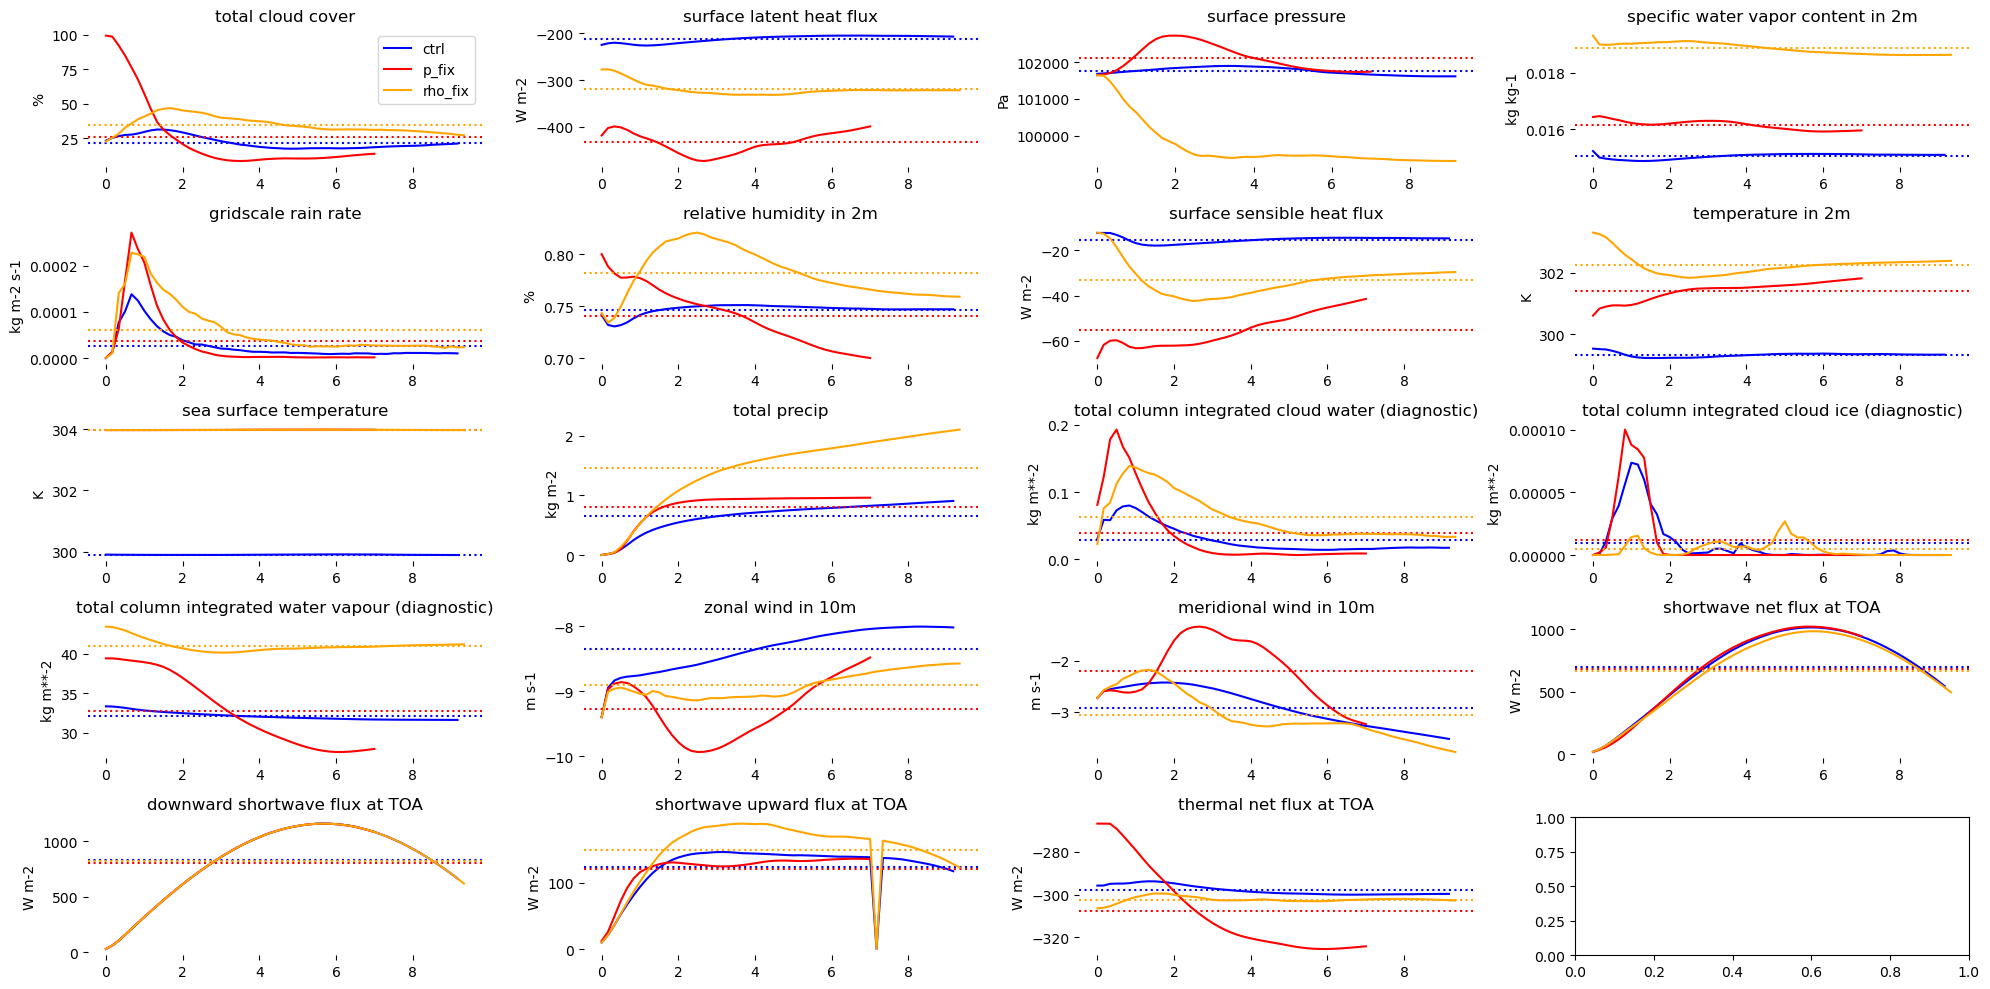

In [10]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import numpy as np
import xarray as xr
import calculations as cc
# import metpy.constants
# from metpy.units import units
import matplotlib.pyplot as plt


import pandas as pd
import plot_utils as pu


import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import xarray as xr    
import numpy as np
import postprocessing as pp
import matplotlib.pyplot as plt

def save_composit_timeseries(path, savename, cut_borders=True):
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell')
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell')
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell')
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell').drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)


def names_dict():
    names = dict()
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_surface_20200109T175000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].long_name
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T100000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].long_name
    return names

def units_dict():
    names = dict()
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_surface_20200109T175000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].units
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T100000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].units
    return names

def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False):
    if not kwargs: kwargs = [dict() for d in data]
    m, n = cc.isqrt(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    names = names_dict()
    units = units_dict()
    for ax, var in zip(np.ravel(axs), list(data[0])):
        for j, d in enumerate(data):
            x = [pd.to_datetime(t) for t in d['time'].values]
            x = [(t - d['time'].values[0]) /np.timedelta64(1,'h')  for t in d['time'].values]
            y = d[var].values
            # if mean: ax.axhline(np.mean(y), label=f'mean({labels[j]})', **kwargs[j], ls=':')
            if mean: ax.axhline(np.mean(y), **kwargs[j], ls=':')
            ax.plot(x, y, label=labels[j], **kwargs[j])
            # pu.rotate_xticks(ax, 45)
            pu.remove_spines(ax)
        ax.set_title(names[var])
        ax.set_ylabel(units[var])
    if verbose: print('done')
    return fig, axs

def fixedfig_all_domain_means_warming_withboundaryzone(mean=False):
    warming_timeseries = 'data/moistadabatic_20230728.nc'
    control_timeseries = 'data/eurecasurface_20230728_8h.nc'
    pressure_drop_timeseries = 'data/old_moistadabatic_20230728.nc'
    
    if not os.path.exists(warming_timeseries): 
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup', warming_timeseries, cut_borders=True)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries, cut_borders=True)
    if not os.path.exists(pressure_drop_timeseries): 
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', pressure_drop_timeseries, cut_borders=True)
    
    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    prev = xr.open_dataset(pressure_drop_timeseries)
    data = {'ctrl':ctrl, 'p_fix':warm, 'rho_fix':prev}
    # data = {'ctrl':ctrl, 'warm':prev}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [{'color' : 'blue'}, {'color' : 'red'}, {'color' : 'orange'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, mean=mean, verbose=False)
    np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs

fig, axs = fixedfig_all_domain_means_warming_withboundaryzone(mean=True)
fig.savefig('img/warming_run_overview.svg')
fig.show()

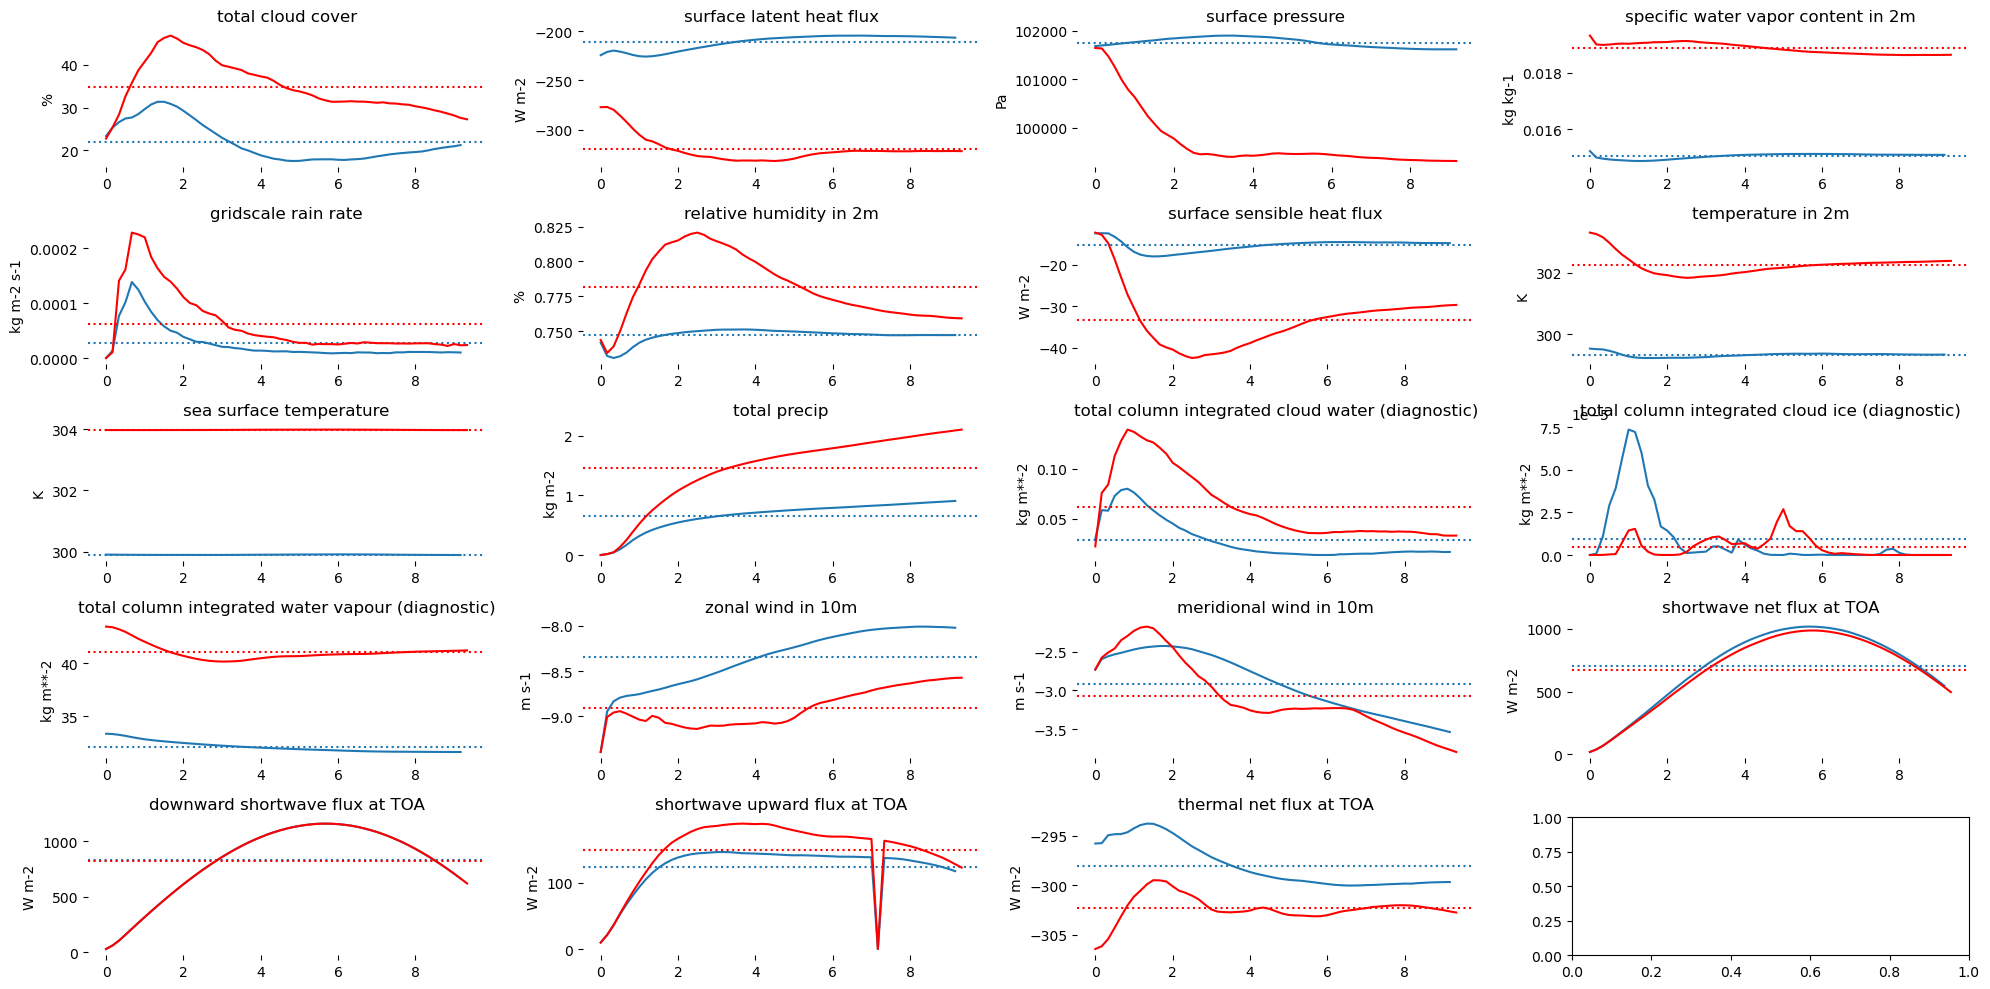

In [2]:
def fixedfig_all_domain_means_warming_withboundaryzone():
    warming_timeseries = 'data/old_moistadabatic_20230728.nc'
    control_timeseries = 'data/eurecasurface_20230728_8h.nc'
    if not os.path.exists(warming_timeseries): 
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', warming_timeseries, cut_borders=True)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries, cut_borders=True)
    
    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    data = {'ctrl':ctrl, 'warm':warm}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [ dict()] * (len(data)-1) + [{'color' : 'red'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False)
    fig.tight_layout()
    return fig, axs

fig, axs = fixedfig_all_domain_means_warming_withboundaryzone()
# fig.savefig('img/warming_run_overview_old.svg')
fig.show()

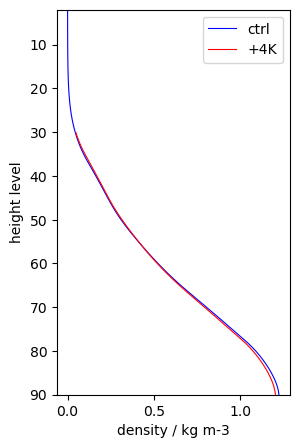

In [5]:
def get_aqua(path='/work/mh0287/m300901/experiments/aquaplanet_00/someinfo'):
    files = [os.path.join(path, f) for f in os.listdir(path) if 'dayavg_atm_3d_ml' in f]
    data = xr.open_mfdataset(files).rename({'ncells':'cell'})
    return data

def get_aqua4k(path='/work/mh0287/m300901/experiments_4k/aquaplanet_00/'):
    files = [os.path.join(path, f) for f in os.listdir(path) if 'dayavg_ml' in f]
    data = xr.open_mfdataset(files)
    files = [os.path.join(path, f) for f in os.listdir(path) if 'grid' in f]
    grid = xr.open_dataset(files[0])
    data = xr.merge([data.rename({'ncells':'cell'}), grid]).drop_vars(list(grid)).drop_dims(['vertex', 'edge'])
    return data

def fig_profiles(var):
    fig, ax = plt.subplots(figsize=(3,5))
    ctrl, warm = get_aqua(), get_aqua4k()
    for d, label, kwargs in zip([ctrl, warm], ['ctrl', '+4K'], [{'color':'blue'}, {'color':'red'}]):
        y = d.height.values
        x = d[var].mean(dim=['cell', 'time'])
        ax.plot(x, y, label=label, lw=.8, **kwargs)

    ax.set_xlabel(f'{ctrl[var].long_name} / {ctrl[var].units}')
    ax.set_ylabel('height level')
    ax.set_ylim(np.max(y), np.min(y))
    ax.legend()
    return fig, ax

fig, ax = fig_profiles('rho')
fig.show()

## Restoring the p-fixed boundary conditions

Creating the *rho-fixed* boundary conditions I overwrote the existing set of *p-fixed* boundary conditions. Now I want to get another few hours of output for the p-fixed run and I have to restore them. First step: create an empty directory structure (it is easier to write into a directory that already exists).

In [13]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import file_handling as fh

model_dir = '/work/mh1126/m300872/unchanged/'
file_list = fh.get_filelist(model_dir, 'initc') + fh.get_filelist(model_dir, 'sst_sic') + fh.get_filelist(model_dir, 'latbc')
fh.create_directory_structure(file_list, '/work/mh1126/m300872/moist_adiabatic_pfix')

In [26]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import subprocess as sup

def latbc_script_body(in_directory, out_directory, division=False, temperatures=(304,300)):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
latbc_files = [f for f in get_filelist(IN_DIRECTORY, 'latbc/') if not 'grid' in f]
create_directory_structure(latbc_files, OUT_DIRECTORY)
if division: latbc_files = sublist(latbc_files, division[0], division[1])

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = apply_warming_p_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)
    
print('latbc_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
print('division: ', division, flush=True)
for f in latbc_files: print(f, flush=True)
print('', flush=True)

latbc_varnames = dict()
latbc_varnames["pressure"] = "pres"
latbc_varnames["temperature"] = "temp"
varnames = get_varnames(latbc_varnames)

args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile, ofile, varnames))

for args in args_list:
    warm_atmospheric_profile(*args)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)

def launch_latbc_scripts(n_scripts=100):
    in_directory = '/work/mh1126/m300872/unchanged/'
    out_directory = '/work/mh1126/m300872/moist_adiabatic_pfix/'
    for script_id in range(n_scripts):
        script = fh.slurm_header(10) + fh.some_module_files() + latbc_script_body(in_directory, out_directory, division=(n_scripts, script_id))
        launch_script(script)

# # launch all scripts
# launch_latbc_scripts()

# relaunch of failed scripts (i receive emails for failed scripts):
in_directory = '/work/mh1126/m300872/unchanged/'
out_directory = '/work/mh1126/m300872/moist_adiabatic_pfix/'
for division in [(100, 0)]:
    print(division)
    latbc_files = [f for f in fh.get_filelist(in_directory, 'latbc/') if not 'grid' in f]
    latbc_files = fh.sublist(latbc_files, division[0], division[1])
    latbc_files.sort()
    for f in latbc_files: print('  ', f)
    script = fh.slurm_header(10) + fh.some_module_files() + latbc_script_body(in_directory, out_directory, division=division)
    launch_script(script)

(100, 0)
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010802.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010803.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010804.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010805.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010806.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010807.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010808.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010809.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010810.nc
   latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010811.nc
Submitted batch job 6652874


In [93]:
# fh.scancel_by_name(name = 'generated_script.py') 

In [10]:
def initc_script_body(in_directory, out_directory):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = get_filelist(IN_DIRECTORY, 'initc')
create_directory_structure(initc_files, OUT_DIRECTORY)

print('initc_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
for f in initc_files: print(f, flush=True)
print('', flush=True)

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = apply_warming_p_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = get_varnames(initcon_varnames)

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
warm_atmospheric_profile(ifile, ofile, varnames)
'''

def launch_initc_script():
    script = fh.slurm_header(10) + fh.some_module_files() + initc_script_body(in_directory='/work/mh1126/m300872/unchanged/', out_directory='/work/mh1126/m300872/moist_adiabatic_pfix/')
    launch_script(script)
    
launch_initc_script()

Submitted batch job 6600980


In [9]:
def sstsic_script_body(in_directory, out_directory, division=False, temperatures=(304,300)):
    return f'''
import netCDF4 as nc
import xarray as xr
import subprocess as sup
# from functions_boundaries import *

IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
temperatures = {temperatures}

print('sstsic_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
print('division: ', division, flush=True)
print('temperatures: ', temperatures, flush=True)

sstsic_files = [f for f in get_filelist(IN_DIRECTORY, 'sst_sic') if 'DOM01' in f or 'DOM02' in f or 'DOM03' in f]
print('all files:', flush=True)
for f in sstsic_files: print('  ', f, flush=True)
if division: sstsic_files = sublist(sstsic_files, division[0], division[1])
# create_directory_structure(sstsic_files, OUT_DIRECTORY)
print('sublist files:', flush=True)
for f in sstsic_files: print('  ', f, flush=True)


# pack arguments
delta = temperatures[1] - temperatures[0]
args_list = list()
for f in sstsic_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,delta))

for args in args_list:
    # copy original file, then overwrite SST timestepwise (file to big to write at once)
    (ifile, ofile, delta) = args
    sup.call(['cp', ifile, ofile])
    time_shape = xr.open_dataset(ifile).time.values.shape
    with nc.Dataset(ofile, mode='a') as fp:
        for i in range(time_shape[0]):
            chunk = xr.open_dataset(ifile)['SST'].isel(time=i).values + delta
            fp['SST'][i] = chunk
'''


def launch_sstsic_script(n_scripts=3, time_limit=15):
    for script_id in range(n_scripts):
        script = fh.slurm_header(time_limit) + fh.some_module_files() + sstsic_script_body(division=(n_scripts, script_id), in_directory='/work/mh1126/m300872/unchanged/', out_directory='/work/mh1126/m300872/moist_adiabatic_pfix/')
        launch_script(script)

launch_sstsic_script(5, 20)

Submitted batch job 6600975
Submitted batch job 6600976
Submitted batch job 6600977
Submitted batch job 6600978
Submitted batch job 6600979


In [6]:
fh.scancel_by_name(name = 'generated_script.py') 

In [15]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import file_handling as fh
import xarray as xr

in_directory='/work/mh1126/m300872/unchanged/'
out_directory='/work/mh1126/m300872/moist_adiabatic/'

latbc_files = [f for f in fh.get_filelist(in_directory, 'latbc/') if not 'grid' in f]
for f in latbc_files[0:3]:
    print(f)
    ctrl = xr.open_dataset(in_directory+f)
    warm = xr.open_dataset(out_directory+f)
    diff = (warm-ctrl).mean(dim=['time','ncells'])
    cell = {'height_3':1}
    var = 'temp'
    print('  ', var, cell, diff[var].sel(cell).values) 
    var = 'qv'
    print('  ', var, cell, diff[var].sel(cell).values) 
    var = 'temp'
    print('  ', var, cell, ctrl.mean(dim=['time','ncells'])[var].sel(cell).values) 
    var = 'qv'
    print('  ', var, cell, ctrl.mean(dim=['time','ncells'])[var].sel(cell).values) 

latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc
   temp {'height_3': 1} 4.0
   qv {'height_3': 1} 1.614617707818157e-06
   temp {'height_3': 1} 235.23293
   qv {'height_3': 1} 3.088052e-06
latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010802.nc
   temp {'height_3': 1} 4.0
   qv {'height_3': 1} 1.6148077823687516e-06
   temp {'height_3': 1} 235.1506
   qv {'height_3': 1} 3.0890747e-06
latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010803.nc
   temp {'height_3': 1} 4.0
   qv {'height_3': 1} 1.617057986106045e-06
   temp {'height_3': 1} 234.76767
   qv {'height_3': 1} 3.0874664e-06


NameError: name 'source' is not defined

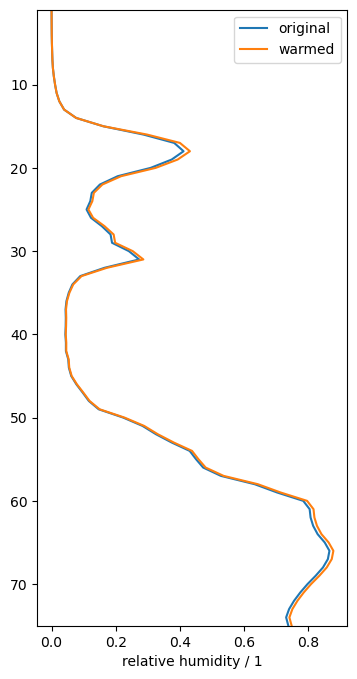

In [6]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import xarray as xr
import calculations as cc
import matplotlib.pyplot as plt
import numpy as np

import importlib
importlib.reload(cc)

path = '/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010812.nc'
profile = xr.open_dataset(path)
profile = profile.isel(time=0).median(dim='ncells', keep_attrs=True)
# for var in list(profile): print(var, profile[var].attrs)
warming = xr.open_dataset(path).isel(time=0).median(dim='ncells')
varnames = cc.get_varnames()
varnames['full_level_height'] = 'height_3'
# warming = cc.apply_warming_p_fixed(profile, varnames)
warming = cc.apply_warming_rho_fixed(warming, varnames)
warming = cc.add_relative_humidity(warming)
profile = cc.add_relative_humidity(profile)

var = 'RH'

fig, ax = plt.subplots(figsize=(4,8))
ax.plot(profile[var].values, profile[profile[var].dims[0]].values, **{'label':'original'})
ax.plot(warming[var].values, profile[profile[var].dims[0]].values, **{'label':'warmed'})
ax.set_ylim(profile[profile.qv.dims[0]].values[-1], profile[profile.qv.dims[0]].values[0])
ax.legend()
# print(profile[var].attrs)
try:    ax.set_xlabel(f'{warming[var].attrs["long_name"]} / {warming[var].attrs["units"]}')
except: pass # ax.set_xlabel(f'{xr.open_dataset(path)[var].attrs["long_name"]} / {xr.open_dataset(path)[var].attrs["units"]}')

fig.show()
source(cc.add_relative_humidity)

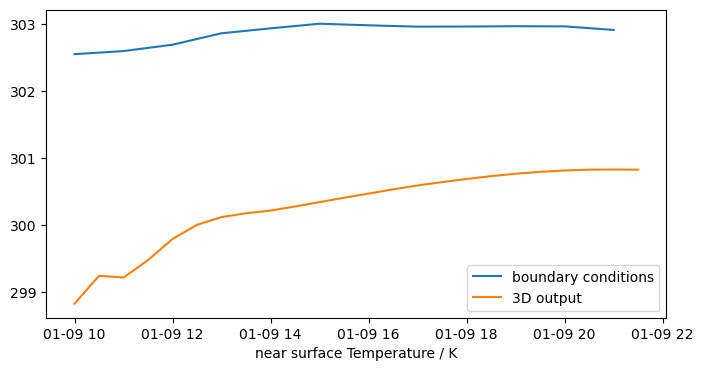

['surface_DOM01', 'surface_DOM02', 'surface_DOM03', 'effective_radius_DOM01', 'effective_radius_DOM02', 'effective_radius_DOM03', 'rttov_DOM01', 'rttov_DOM02', '3D_DOM01', '3D_DOM02', '3D_DOM03', 'pressure_lev_DOM03', 'radiation_DOM01', 'radiation_DOM02', 'meteogram_BCO_DOM01', 'synthetic_radar_BCO_DOM01', 'meteogram_BCO_DOM02', 'synthetic_radar_BCO_DOM02', 'meteogram_NTAS_DOM01', 'synthetic_radar_NTAS_DOM01', 'meteogram_NTAS_DOM02', 'synthetic_radar_NTAS_DOM02', 'meteogram_NTAS_DOM03', 'synthetic_radar_NTAS_DOM03', 'meteogram_c_center_DOM01', 'synthetic_radar_c_center_DOM01', 'meteogram_c_center_DOM02', 'synthetic_radar_c_center_DOM02', 'meteogram_c_center_DOM03', 'synthetic_radar_c_center_DOM03', 'meteogram_c_east_DOM01', 'synthetic_radar_c_east_DOM01', 'meteogram_c_east_DOM02', 'synthetic_radar_c_east_DOM02', 'meteogram_c_east_DOM03', 'synthetic_radar_c_east_DOM03', 'meteogram_c_north_DOM01', 'synthetic_radar_c_north_DOM01', 'meteogram_c_north_DOM02', 'synthetic_radar_c_north_DOM02'

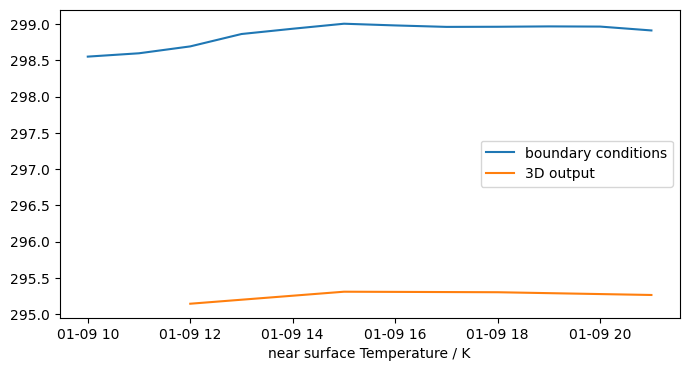

In [7]:
# open boundary conditions
path = '/work/mh1126/m300872/unchanged/latbc/'
# path = '/work/mh1126/m300872/moist_adiabatic_pfix/latbc/'
files = fh.list_files(path, ['PR1250m'], full_path=True)[0:200]
dataset = xr.open_mfdataset(files)
dataset = dataset.rename({'height':'halflevel_height'})
dataset = dataset.rename({'height_3':'height'})
dataset = dataset.drop_vars(['clon_bnds', 'clat_bnds', 'height_bnds', 'height_3_bnds', 'z_ifc', 'w'])
dataset = pp.clean_volume_data(dataset)
rename_vars={'ncells':'cell', 'height':'halflevel_height', 'height_3':'height'}
dataset = dataset.mean(dim=['cell'], keep_attrs=True)
maske = ((dataset.time >= limits[0] ) &
         (dataset.time <= limits[-1]) ).compute()
dataset = dataset.sel({'time' : maske})
data_bc = dataset
# open 3d output
import eurec4a
print(list(eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control))
dataset = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control[f'3D_DOM01'].to_dask()
# dataset = dataset.drop_vars(['height_bnds', 'cloud_num'])
maske = ((dataset.time >= limits[0] ) &
         (dataset.time <= limits[-1]) ).compute()
dataset = dataset.sel({'time' : maske})
dataset = dataset.mean(dim=['cell'], keep_attrs=True)
data_3d = dataset

var = 'temp'

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(data_bc.time.values, data_bc.sel(height=data_bc.height.values[-1])[var], **{'label':'boundary conditions'})
ax.plot(data_3d.time.values, data_3d.sel(height=data_3d.height.values[-1])[var], **{'label':'3D output'})
ax.legend()
try:    ax.set_xlabel(f'near surface {data_3d[var].attrs["long_name"]} / {data_3d[var].attrs["units"]}')
except: pass # ax.set_xlabel(f'{xr.open_dataset(path)[var].attrs["long_name"]} / {xr.open_dataset(path)[var].attrs["units"]}')

fig.show()



       

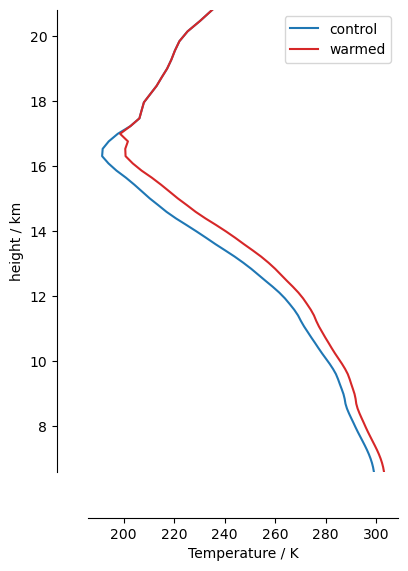

In [39]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import xarray as xr
import file_handling as fh
import metpy.calc
import metpy.units
import postprocessing as pp
# import eurec4a
import calculations as cc

import matplotlib.pyplot as plt
import plot_utils as pu

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files[0])
    dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    return dataset

def ax_vertical_profile(ax, dataset, var, kwargs={}):
    ax.plot(dataset[var], dataset[dataset[var].dims[0]].values / 1000, **kwargs)
    ax.set_ylim(dataset[dataset[var].dims[0]].values[-1] / 1000, dataset[dataset[var].dims[0]].values[0] / 1000)
    ax.set_ylabel('height / km')
    try: ax.set_xlabel(dataset[var].attrs['long_name'] + ' / ' + dataset[var].attrs['units'] )
    except: pass
    # https://matplotlib.org/2.0.2/examples/pylab_examples/spine_placement_demo.html
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('axes', -.1)) #
    ax.spines['left'  ].set_position(('axes', -.1)) # 
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    return ax

var = 'temp'
dataset = open_boundary_conditions().isel(time=0)

fig, ax = plt.subplots(figsize=(4,6))
dataset = cc.add_relative_humidity(dataset)
dataset = cc.replace_level_with_height(dataset, dataset[var].dims[0])
ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:blue', 'label':'control'})
dataset = cc.apply_warming_rho_fixed(dataset)
dataset = cc.add_relative_humidity(dataset)
ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:red', 'label':'warmed'})
ax.legend()

fig.show()

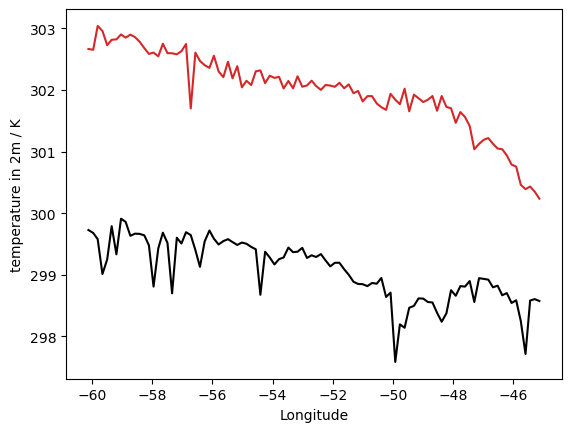

In [13]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import file_handling as fh
import postprocessing as pp
import matplotlib.pyplot as plt
import calculations as cc

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(varname='t_2m', time_index=143):
    fig, ax = plt.subplots()
    
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup'
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    data = data.isel(time=time_index)
    data = pp.add_grid(data)
    timestep = data.time.values
    ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

    data = fh.eureca_data_from_keywords(['surface','DOM01'])
    data = data.sel(time=timestep)
    data = pp.add_grid(data)
    ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
    return fig, ax

fig, ax = fig_compare_longitudinal_sections('t_2m')
fig.show()

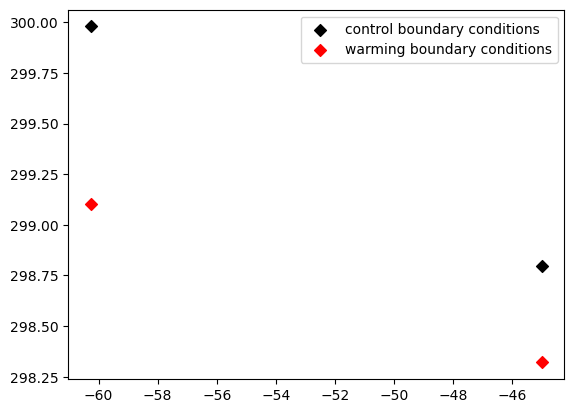

In [24]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc
import matplotlib.pyplot as plt

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files[0])
    # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.rename({'ncells':'cell'})
    dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    return dataset

def ax_longitudinal_section_boundaries(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

fig, ax = plt.subplots()
var = 'temp'

kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
data = open_boundary_conditions()
lon = np.asarray(cc.minmax(data.lon))
lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
data = cc.select_nearest_cells(data, lon, lat)
data = data.isel(time=0)
data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
ax.scatter(data.lon.values, data[var].values, **kwargs)

kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic/latbc/')
lon = np.asarray(cc.minmax(data.lon))
lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
data = cc.select_nearest_cells(data, lon, lat)
data = data.isel(time=0)
data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
ax.scatter(data.lon.values, data[var].values, **kwargs)

ax.legend()
# ax = ax_longitudinal_section_boundaries(ax, data, var, kwargs={})
fig.show()

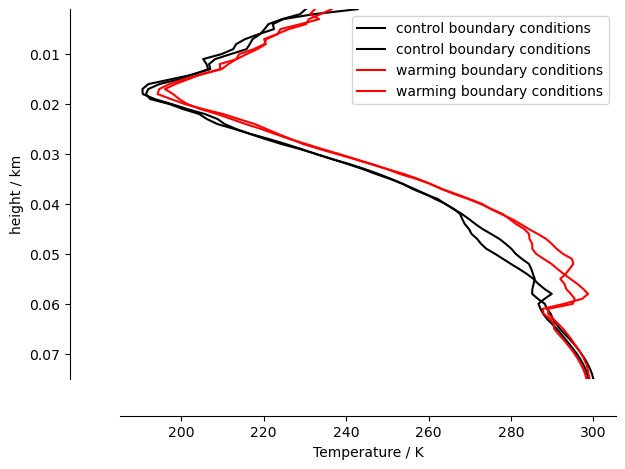

In [34]:
import plot_utils as pu

fig, ax = plt.subplots()
var = 'temp'

kwargs = {'label':'control boundary conditions', 'color':'black'}
data = open_boundary_conditions()
lon = np.asarray(cc.minmax(data.lon))
lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
data = cc.select_nearest_cells(data, lon, lat)
data = data.isel(time=0)
# data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
pu.ax_vertical_profile(ax, data.isel(cell=0), var, kwargs=kwargs)
pu.ax_vertical_profile(ax, data.isel(cell=1), var, kwargs=kwargs)

kwargs = {'label':'warming boundary conditions', 'color':'red'}
data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic/latbc/')
lon = np.asarray(cc.minmax(data.lon))
lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
data = cc.select_nearest_cells(data, lon, lat)
data = data.isel(time=0)
# data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
# ax.scatter(data.lon.values, data[var].values, **kwargs)
pu.ax_vertical_profile(ax, data.isel(cell=0), var, kwargs=kwargs)
pu.ax_vertical_profile(ax, data.isel(cell=1), var, kwargs=kwargs)

ax.legend()
# ax = ax_longitudinal_section_boundaries(ax, data, var, kwargs={})
fig.show()

In [21]:
fig, ax = fig_compare_longitudinal_sections('qv_2m')
fig.show()

NameError: name 'fig_compare_longitudinal_sections' is not defined

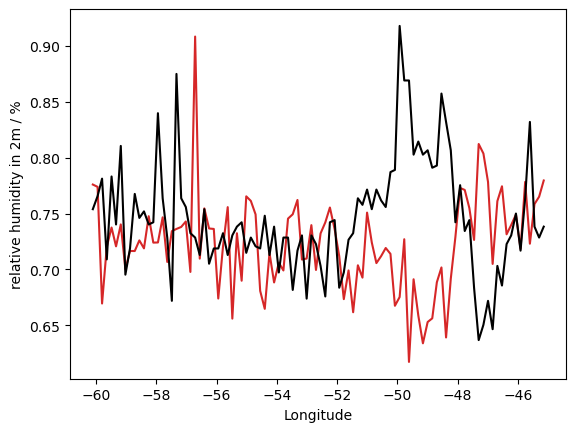

In [32]:
fig, ax = fig_compare_longitudinal_sections('rh_2m')
fig.show()

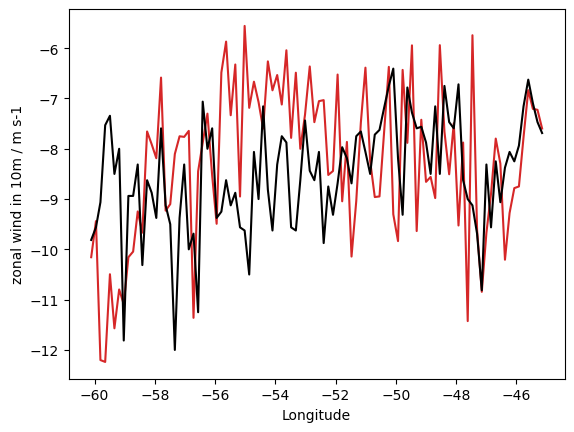

In [34]:
fig, ax = fig_compare_longitudinal_sections('u_10m')
fig.show()

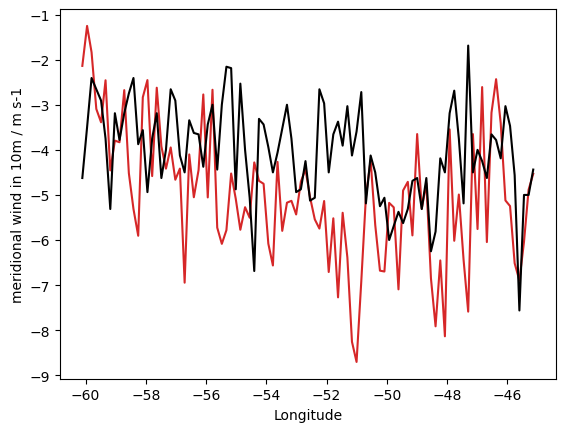

In [35]:
fig, ax = fig_compare_longitudinal_sections('v_10m')
fig.show()

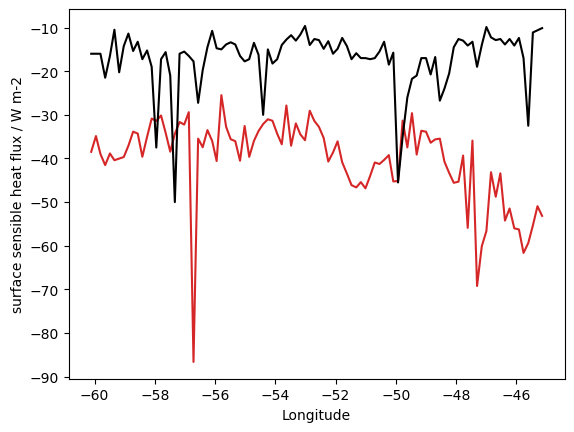

In [36]:
fig, ax = fig_compare_longitudinal_sections('shfl_s')
fig.show()

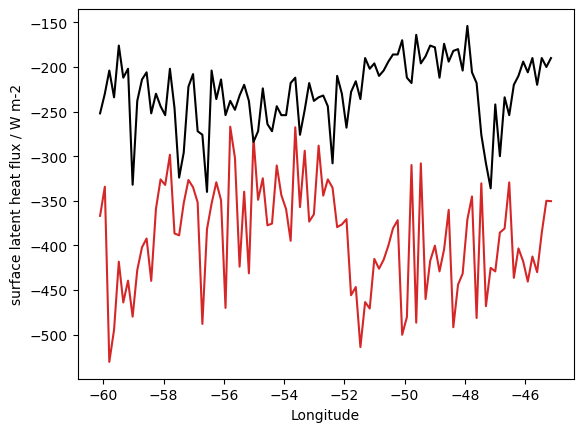

In [37]:
fig, ax = fig_compare_longitudinal_sections('lhfl_s')
fig.show()

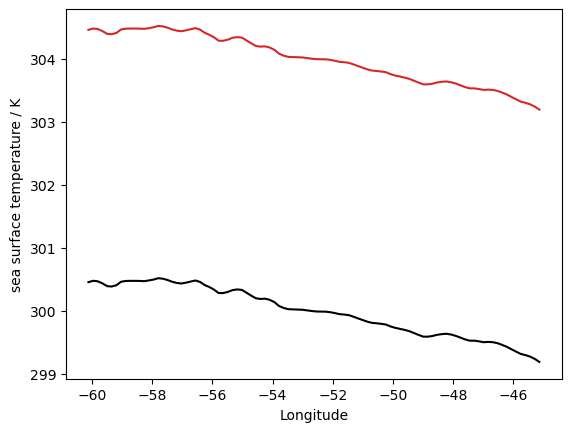

In [38]:
fig, ax = fig_compare_longitudinal_sections('t_seasfc')
fig.show()

In [15]:
data

<xarray.Dataset>
Dimensions:        (cell: 100)
Coordinates:
    lat            (cell) float64 12.23 12.24 12.24 12.24 ... 12.24 12.24 12.24
    lon            (cell) float64 -60.26 -60.11 -59.95 ... -45.29 -45.14 -44.99
  * cell           (cell) int64 10258 3147286 3144600 ... 350548 250046 2588
    time           datetime64[ns] 2020-01-09T20:00:00
Data variables: (12/15)
    u_10m          (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    v_10m          (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    rh_2m          (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    t_2m           (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    qv_2m          (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    t_seasfc       (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    ...             ...
    tqc_dia        (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    tqi_dia        (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    rain_gsp_rate  (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    tot_prec       (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    clct           (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    pres_sfc       (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

In [4]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import subprocess as sup

def latbc_script_body(in_directory, out_directory, division=False, temperatures=(304,300)):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
latbc_files = [f for f in get_filelist(IN_DIRECTORY, 'latbc/') if not 'grid' in f]
create_directory_structure(latbc_files, OUT_DIRECTORY)
if division: latbc_files = sublist(latbc_files, division[0], division[1])

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = apply_warming_p_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)
    
print('latbc_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
print('division: ', division, flush=True)
for f in latbc_files: print(f, flush=True)
print('', flush=True)

latbc_varnames = dict()
latbc_varnames["pressure"] = "pres"
latbc_varnames["temperature"] = "temp"
varnames = get_varnames(latbc_varnames)

args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile, ofile, varnames))

for args in args_list:
    warm_atmospheric_profile(*args)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)

def launch_latbc_scripts(n_scripts=100,
                        in_directory='/work/mh1126/m300872/unchanged/',
                        out_directory='/work/mh1126/m300872/moist_adiabatic_pfix/'):
    for script_id in range(n_scripts):
        script = fh.slurm_header(10) + fh.some_module_files() + latbc_script_body(in_directory, out_directory, division=(n_scripts, script_id))
        launch_script(script)

        

in_directory = '/work/mh1126/m300872/eurecaDEV_control/'
out_directory = '/work/mh1126/m300872/eurecaDEV_4k_rhofix'


# # launch all scripts
# launch_latbc_scripts(100, in_directory, out_directory)

# relaunch of failed scripts (i receive emails for failed scripts):
for division in [(10, 0)]:
    print(division)
    latbc_files = [f for f in fh.get_filelist(in_directory, 'latbc/') if not 'grid' in f]
    latbc_files = fh.sublist(latbc_files, division[0], division[1])
    latbc_files.sort()
    for f in latbc_files: print('  ', f)
    script = fh.slurm_header(10) + fh.some_module_files() + latbc_script_body(in_directory, out_directory, division=division)
    launch_script(script)
    


(10, 0)
   /home/m/m300872/warm_eurec4a/03_adiabatic_warming/latbc/20200215/latbc_Testdomain_land_DOM01_DOM01_2020021500.nc
Submitted batch job 7937320


In [ ]:
def initc_script_body(in_directory, out_directory):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = get_filelist(IN_DIRECTORY, 'initc')
create_directory_structure(initc_files, OUT_DIRECTORY)

print('initc_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
for f in initc_files: print(f, flush=True)
print('', flush=True)

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = apply_warming_p_fixed(d, varnames=varnames)
    d.to_netcdf(ofile)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = get_varnames(initcon_varnames)

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
warm_atmospheric_profile(ifile, ofile, varnames)
'''

def launch_initc_script():
    script = fh.slurm_header(10) + fh.some_module_files() + initc_script_body(in_directory='/work/mh1126/m300872/unchanged/', out_directory='/work/mh1126/m300872/moist_adiabatic_pfix/')
    launch_script(script)
    
launch_initc_script()

In [ ]:
def sstsic_script_body(in_directory, out_directory, division=False, temperatures=(304,300)):
    return f'''
import netCDF4 as nc
import xarray as xr
import subprocess as sup
# from functions_boundaries import *

IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
temperatures = {temperatures}

print('sstsic_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
print('division: ', division, flush=True)
print('temperatures: ', temperatures, flush=True)

sstsic_files = [f for f in get_filelist(IN_DIRECTORY, 'sst_sic') if 'DOM01' in f or 'DOM02' in f or 'DOM03' in f]
print('all files:', flush=True)
for f in sstsic_files: print('  ', f, flush=True)
if division: sstsic_files = sublist(sstsic_files, division[0], division[1])
# create_directory_structure(sstsic_files, OUT_DIRECTORY)
print('sublist files:', flush=True)
for f in sstsic_files: print('  ', f, flush=True)


# pack arguments
delta = temperatures[1] - temperatures[0]
args_list = list()
for f in sstsic_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,delta))

for args in args_list:
    # copy original file, then overwrite SST timestepwise (file to big to write at once)
    (ifile, ofile, delta) = args
    sup.call(['cp', ifile, ofile])
    time_shape = xr.open_dataset(ifile).time.values.shape
    with nc.Dataset(ofile, mode='a') as fp:
        for i in range(time_shape[0]):
            chunk = xr.open_dataset(ifile)['SST'].isel(time=i).values + delta
            fp['SST'][i] = chunk
'''


def launch_sstsic_script(n_scripts=3, time_limit=15):
    for script_id in range(n_scripts):
        script = fh.slurm_header(time_limit) + fh.some_module_files() + sstsic_script_body(division=(n_scripts, script_id), in_directory='/work/mh1126/m300872/unchanged/', out_directory='/work/mh1126/m300872/moist_adiabatic_pfix/')
        launch_script(script)

launch_sstsic_script(5, 20)

In [11]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh
import xarray as xr

in_directory = '/work/mh1126/m300872/eurecaDEV_control/'
netcdfs = [f for f in fh.list_files(in_directory) if f.endswith('.nc')]
for f in netcdfs: 
    try: c = xr.open_dataset(os.path.join(in_directory,f)).cell.shape
    except: 
        try: c = xr.open_dataset(os.path.join(in_directory,f)).ncells.shape
        except: 
            c = 0
        
    print(f, c)
    # print(xr.open_dataset(f))

extpar/external-parameter-icon-EUREC4A-PR1250m-DOM01-tiles.nc (4528560,)
extpar/external-parameter-icon-EUREC4A-PR1250m-DOM02-tiles.nc (11792076,)
extpar/external-parameter-icon-EUREC4A-PR1250m-DOM03-tiles.nc (24469588,)
extpar/external_parameter_icon_GOES16_test_DOM01_tiles.nc (503920,)
extpar/external_parameter_icon_GOES16_test_DOM02_tiles.nc (503912,)
extpar/external_parameter_icon_Testdomain_land_DOM01_DOM01_tiles.nc (512540,)
extpar/external_parameter_icon_Testdomain_land_DOM01_DOM02_tiles.nc (512592,)
extpar/external_parameter_icon_Testdomain_land_DOM01_DOM03_tiles.nc (512640,)
grids/GOES16_test_DOM01.nc (503920,)
grids/GOES16_test_DOM01.parent.nc (125980,)
grids/GOES16_test_DOM01_CellArea.nc (503920,)
grids/GOES16_test_DOM02.nc (503912,)
grids/Testdomain_land_DOM01_DOM01.nc (512540,)
grids/Testdomain_land_DOM01_DOM01_CellArea.nc (512540,)
grids/Testdomain_land_DOM01_DOM02.nc (512592,)
grids/Testdomain_land_DOM01_DOM02_CellArea.nc (512592,)
grids/Testdomain_land_DOM01_DOM03.nc (5

In [40]:
from datetime import datetime

def convert_timestamp_to_date(timestamp):
    # Parse the timestamp string into a datetime object
    datetime_obj = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%SZ')
    # Convert the datetime object to the desired date format
    formatted_date = datetime_obj.strftime('%Y%m%d')
    return formatted_date

def process_date(start_date):
    # mimics `echo ${start_date%%:*} | sed 's/\-//g' | sed 's/T//g'`
    # Extract date part before the first colon
    date_part = start_date.split(':')[0]
    # Remove hyphens '-'
    date_part = date_part.replace('-', '')
    # Remove 'T'
    date_part = date_part.replace('T', '')    
    return date_part

# start_date="2020-01-09T10:00:00Z"
start_date="2020-02-06T09:00:00Z"
BASE_DIR='/work/mh1126/m300872/eurecaDEV_control/'
LATBC_GRID = f'{BASE_DIR}/latbc/lateral_boundary_DOM01.grid.nc'
GRID_DIR = f'{BASE_DIR}/grids'
INIT_DIR = f'{BASE_DIR}/initc/{convert_timestamp_to_date(start_date)}'
LATBC_PATH = f'{BASE_DIR}/latbc'
SSTSIC_PATH = f'{BASE_DIR}/sst_sic/data'
EXTPAR_PATH = f'{BASE_DIR}/extpar'

files = [
 f'{GRID_DIR}/GOES16_test_DOM01.nc', # ./grid_dynamics_1.nc
 f'{GRID_DIR}/GOES16_test_DOM01.nc', # ./grid_dynamics_2.nc
 f'{INIT_DIR}/initc_GOES16_test_DOM01_{process_date(start_date)}.nc', # dwdFG_R2B12_DOM01.nc
 f'{SSTSIC_PATH}/sst_sic_DOM01.nc', # ./SSTSIC_grid_dynamics_1.nc
 f'{SSTSIC_PATH}/sst_sic_DOM02.nc', # ./SSTSIC_grid_dynamics_2.nc
 f'{EXTPAR_PATH}/external_parameter_icon_GOES16_test_DOM01_tiles.nc', # extpar_grid_dynamics_1.nc
 f'{EXTPAR_PATH}/external_parameter_icon_GOES16_test_DOM01_tiles.nc', # extpar_grid_dynamics_2.nc
 f'{EXTPAR_PATH}/external_parameter_icon_GOES16_test_DOM01_tiles.nc' # extpar_grid_dynamics_3.nc
]

for f in files:
    print(f, os.path.exists(f))
    d = xr.open_dataset(f)
    try: print(f'\t{d.ncells.shape}')
    except: print(f'\t{d.cell.shape}')
    # try: print(f'\t{d.time.values}')
    # except: pass

/work/mh1126/m300872/eurecaDEV_control//grids/GOES16_test_DOM01.nc True
	(503920,)
/work/mh1126/m300872/eurecaDEV_control//grids/GOES16_test_DOM01.nc True
	(503920,)
/work/mh1126/m300872/eurecaDEV_control//initc/20200206/initc_GOES16_test_DOM01_2020020609.nc True
	(503920,)
/work/mh1126/m300872/eurecaDEV_control//sst_sic/data/sst_sic_DOM01.nc True
	(512540,)
/work/mh1126/m300872/eurecaDEV_control//sst_sic/data/sst_sic_DOM02.nc True
	(512592,)
/work/mh1126/m300872/eurecaDEV_control//extpar/external_parameter_icon_GOES16_test_DOM01_tiles.nc True
	(503920,)
/work/mh1126/m300872/eurecaDEV_control//extpar/external_parameter_icon_GOES16_test_DOM01_tiles.nc True
	(503920,)
/work/mh1126/m300872/eurecaDEV_control//extpar/external_parameter_icon_GOES16_test_DOM01_tiles.nc True
	(503920,)


In [37]:

fh.list_files(f'{BASE_DIR}/initc')


['./initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
 './initc_EUREC4A_PR1250m_DOM01_2020012410.nc',
 './initc_EUREC4A_PR1250m_DOM01_2020012510.nc',
 './initc_EUREC4A_PR1250m_DOM01_2020020110.nc',
 '20200206/.gitignore',
 '20200206/initc_GOES16_test_DOM01_2020020609.nc',
 '20200206/initc_GOES16_test_DOM01_2020020609.nc.dvc',
 '20200206/initc_GOES16_test_DOM01_2020020610.nc',
 '20200206/initc_GOES16_test_DOM01_2020020610.nc.dvc',
 '20200206/initc_Testdomain_land_DOM01_DOM01_2020020610.nc',
 '20200211/initc_Testdomain_land_DOM01_DOM01_2020021110.nc',
 '20200212/initc_Testdomain_land_DOM01_DOM01_2020021210.nc',
 '20200215/initc_Testdomain_land_DOM01_DOM01_2020021510.nc']

In [24]:

fh.list_files(f'{BASE_DIR}/latbc')


['./.gitignore',
 './lateral_boundary_DOM01.grid.nc',
 './lateral_boundary_DOM01.grid.nc.dvc',
 '20200206/.gitignore',
 '20200206/latbc_GOES16_test_DOM01_2020020610.nc.dvc',
 '20200206/latbc_GOES16_test_DOM01_2020020611.nc.dvc',
 '20200206/latbc_GOES16_test_DOM01_2020020612.nc.dvc',
 '20200215/latbc_Testdomain_land_DOM01_DOM01_2020021500.nc',
 '20200215/latbc_Testdomain_land_DOM01_DOM01_2020021510.nc',
 '20200215/latbc_Testdomain_land_DOM01_DOM01_2020021511.nc',
 '20200215/latbc_Testdomain_land_DOM01_DOM01_2020021512.nc',
 '20200215/latbc_Testdomain_land_DOM01_DOM01_2020021513.nc']

In [29]:
path = os.path.join(f'{BASE_DIR}/initc','20200206/initc_GOES16_test_DOM01_2020020609.nc')
xr.open_dataset(path).time.values

array(['2020-02-06T09:00:00.000000000'], dtype='datetime64[ns]')